In [2]:
# ------------------------------mount drive-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/nonlinear-sys-id/simple\ pendulum/
# !ls
# !ls "/content/drive/MyDrive/Colab\ Notebooks/nonlinear-sys-id/quadrotor/"

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/nonlinear-sys-id/simple pendulum


In [3]:
import numpy as np
from scipy.stats import truncnorm
import random
import matplotlib.pyplot as plt
import math


g = 9.81  # (m/s^2)  gravity constant
dt = 0.001  # time_step for discrete-time system


def system_parameters():
    m = 0.5  # (kg)    mass
    l = 0.1  # (m) distance between the rotor and the center of mass
    b = 0.1  # drag constant of the rotor
    return m, l, b

def generate_u(input_, time_hor, s_, mean, std, u_max, lb, ub):  # noise in control input
    if input_ == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        return r1
    elif input_ == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1
    elif input_ == "bernouli":
        np.random.seed(s_)
        r0 = np.random.rand(time_hor)
        r1 = []
        for k in range(len(r0)):
          if r0[k] < 0.5:
            r1.append(0.5)
          else:
            r1.append(-0.5)
        return r1

def generate_w(distr, time_hor, s_, mean, std, w_max, lb, ub):  # disturbance
    if distr == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r2 = rv.rvs(size=time_hor)
        return r1, r2
    elif distr == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r2 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1, r2
    elif distr == "bernouli":
        np.random.seed(s_)
        r01 = np.random.rand(time_hor)
        r02 = np.random.rand(time_hor)
        r1 = []
        r2 = []
        for k in range(len(r01)):
          if r01[k] < 0.5:
            r1.append(100)
          else:
            r1.append(-100)
        for k in range(len(r02)):
          if r02[k] < 0.5:
            r2.append(100)
          else:
            r2.append(-100)
        return r1, r2

class SimplePendulumDynamics:
    def __init__(self, distr, input):
        self.state = None
        self.u0 = None
        self.distr = distr
        self.input = input
        self.m, self.l, self.b = system_parameters()
        self.alpha_list = []
        self.omega_list = []
        self.phi_s_u_list = []
        self.b_s_list = []
        self.phi_list = []
        self.state_list = []

    def plot_trajectory(self):
        t_list = np.array(range(len(self.alpha_list))) * dt
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)   # wspace: space between subplots in a row

        # print(np.sin(np.array(self.alpha_list)))
        axs[0].plot(t_list, np.sin(np.array(self.alpha_list)), label='$sin(\\alpha)$')
        axs[0].plot(t_list, np.array(self.alpha_list), label='$\\alpha$')
        # axs[0].scatter(t_list, np.sin(np.array(self.alpha_list)), marker='o')
        # plt.title("Quadrotor's Position")
        axs[0].set_xlabel('time (s)')
        axs[0].set_ylabel('$\\alpha$ ($rad$)')
        axs[0].legend()

        # print(np.array(self.omega_list))
        axs[1].plot(t_list, self.omega_list, label='$\omega$')
        # axs[1].scatter(t_list, self.omega_list, marker='o')
        # plt.title("Quadrotor's Angular Velocity")
        axs[1].set_xlabel('time (s)')
        axs[1].set_ylabel('$\omega$ ($rad/s^{2}$)')
        axs[1].legend()

        plt.show()

    def update_feature_list(self, phi_s_u, s_, s, ex):
        self.phi_s_u_list.append(phi_s_u)
        self.b_s_list.append(s - s_ - ex)

    def update_feat(self, y):
        self.phi_list.append(y)


    def get_trajectory_3(self, x0, time_hor, s_u, s_w, param_u, mult_u, param_w, mult_w):

        # ----------------------------------------- initial states -----------------------------------------------------
        self.state = x0
        x = np.array(x0)
        alpha = x[0]  # angle
        omega = x[1]  # angular velocity

        #  ------------------------------------- Storing the states - ---------------------------------------------
        self.alpha_list = [alpha]
        self.omega_list = [omega]
        self.state_list = [np.array([alpha, omega])]

        if self.input == "trunc_guass":
          u_max_ = param_u[2]
        else:
          u_max_ = 1.0

        if self.distr == "trunc_guass":
          w_max_ = param_w[2]
        else:
          w_max_ = 1.0

        # -----------------  random noise and disturbance generation ---------------------------------------------------
        U1_list = generate_u(self.input, time_hor, s_u, mean=param_u[0], std=param_u[1], u_max=u_max_, lb=param_u[0], ub=param_u[1])
        W1_list, W2_list = generate_w(self.distr, time_hor, s_w, mean=param_w[0], std=param_w[1], w_max=w_max_, lb=param_w[0], ub=param_w[1])

        for t in range(time_hor):

            s_ = omega

            # ------------------  noise in control input  (for exploration)  ----------------------------------------
            u1 = U1_list[t]

            # if t == 0:
            #   u1 = 0

            # ----------------   noise in control input  (for exploration)  -----------------------------------------
            w1 = mult_w[0] * W1_list[t]
            w2 = mult_w[1] * W2_list[t]

            # ----------------------------------------  PD control + noise  ------------------------------------------

            # ------------------------------------------  Dynamic model ----------------------------------------------

            alpha_dot = omega + w1
            omega_dot = - self.b * omega / (self.m * self.l * self.l)  - math.sin(alpha) * g / self.l + u1 / (self.m * self.l * self.l) + w2

            phi_s_u = np.array([-omega, -g*math.sin(alpha), u1])
            self.update_feat(phi_s_u)

            # -------------------------------------- Updating the states --------------------------------------------
            alpha = alpha + dt * alpha_dot
            omega = omega + dt * omega_dot

            self.state = np.array([alpha, omega])
            # self.u0 = u1

            s = omega

            self.update_feature_list(dt * phi_s_u, s_, s, 0.)

            # ------------------------------------- Storing the states ----------------------------------------------
            self.alpha_list.append(alpha)
            self.omega_list.append(omega)
            self.state_list.append(np.array([alpha, omega]))


# Getting Trajectory Data of Quadrotor

In [ ]:
print(np.linalg.norm(Phi_list[-1][-1]))
print(Phi_list[-1][-1])


0.3608924137096501
[-0.3402195  -0.0062849   0.12022697]


In [105]:
L = []
step = 0.1
n_step = 2 / step
l1 = [-1 + step*interval for interval in range(int(np.ceil(n_step)+1))]
for k in range(len(l1)):
  ln = np.sqrt(1 - abs(l1[k]))
  if ln == 0:
    l2 = [0]
  else:
    n_step = 2 * ln / step
    l2 = [-ln + step*interval for interval in range(int(np.ceil(n_step)+1))]
    for j in range(len(l2)):
      l3 = np.sqrt(1 - (l1[k]*l1[k]+l2[j]*l2[j]))
      l = np.array([l1[k], l2[j], l3])
      L.append(l)
L.append(np.array([1, 0, 0]))
L.append(np.array([0, 1, 0]))
L.append(np.array([0, 0, 1]))

In [4]:
# --------------------------import packages-------------------------------------
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)

# ----------------------import classes and functions----------------------------
# from pendulum_dynamics import SimplePendulumDynamics

# --------------------------ground_truth parameters-----------------------------
m, l, b = system_parameters()
ground_truth = [b / m / l / l, 1 / l, 1 / m / l / l]

print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

n_epoch = 1             # number trajectories
max_time_hor = 1000      # maximum trajectory length

# ------------------------------disturbacne-------------------------------------
disturbance: str = "trunc_guass"
parameter_dist = [0.0, 0.001, 1/0.001]  # mean and std

# disturbance: str = "bernouli"

# disturbance: str = "uniform"
# parameter_dist = [-0.1, 0.1]  # lb and ub

# mult_w = [math.pi * 10, 1]

mult_w = [1, 1]

seeds_w = range(300, 500) # fixing seeds
w_max = 0.03             # maximum disturbance (required to run set membership)

# ---------------------------------noise----------------------------------------
c_input: str = "trunc_guass"
b = 0.05
parameter_input = [0.0, b, 1/b]  # mean and std and scale

# c_input: str = "bernouli"

# c_input: str = "uniform"
# parameter_input = [-0.1, 0.1]  # lb and ub

mult_u = [1]

seeds_u = range(100, 300)   # fixing seeds

print('------------------Getting Trajectory Data of Quadrotor-----------------')

# theta_hat_list = []
Delta_S_list = []
Phi_S_U_list = []
Phi_list = []
State_list = []

for e in range(n_epoch):
  x0 = [0.0 , 0.0]
  pend = SimplePendulumDynamics(c_input, disturbance)
  pend.get_trajectory_3(x0, max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist, mult_w)
  # print("---------------------------------------------------------------------")
  print("e = ", e + 1)
  # pend.plot_trajectory()

  Delta_S_list.append(pend.b_s_list)
  Phi_S_U_list.append(pend.phi_s_u_list)     # nonlinear feature vector

  Phi_list.append(pend.phi_list)
  State_list.append(pend.state_list)

print('-------------------------------Data Saved------------------------------')

-----------------------------------------------------------------------
ground truth =  [20.0, 10.0, 200.0]
-----------------------------------------------------------------------
------------------Getting Trajectory Data of Quadrotor-----------------
e =  1
-------------------------------Data Saved------------------------------


In [129]:
def feature_(s_, phi__, w1, w2, u):

  m, l, b = system_parameters()
  dt = 0.001
  alpha_ = s_[0] + dt * s_[1] + mult_w[0] * w1 * dt

  theta_star = dt * np.array([1 / dt - b / m / l / l, 1 / l, 1 / m / l / l])
  omega_ = np.dot(theta_star, phi__) + mult_w[1] * w2 * dt
  phi_ = np.array([omega_, - g * math.sin(alpha_), u])

  return phi_

def estimate_max_prob(x0_, time_hor_, num_traj, num_iter, c, c_input, disturbance, param_u, mult_u, param_w, mult_w):
  step = 0.1
  probs = []
  stds = []
  b_phi = []
  n_ = 0
  x1 = x0_
  e = 0

  if c_input == "trunc_guass":
    u_max_ = param_u[2]
  else:
    u_max_ = 1.0

  if disturbance == "trunc_guass":
    w_max_ = param_w[2]
  else:
    w_max_ = 1.0

  seeds_u = range(100, 100+num_iter*len(L)*time_hor_)
  seeds_w = range(3000, 3000+num_iter*len(L)*time_hor_)

  U1_list = generate_u(c_input, num_iter*len(L)*time_hor_, seeds_u, mean=param_u[0], std=param_u[1], u_max=u_max_, lb=param_u[0], ub=param_u[1])
  W1_list, W2_list = generate_w(disturbance, num_iter*len(L)*time_hor_, seeds_w, mean=param_w[0], std=param_w[1], w_max=w_max_, lb=param_w[0], ub=param_w[1])
  ind = 0

  b_phi_ = []
  for tt in range(time_hor_):

    x0 = x1
    # print("-------------------------")
    # print("T = ", tt+1)

    for k in range(len(L)):

      l = L[k]
      n = 0

      for j in range(num_iter):

        y = feature_(State_list[e][tt], Phi_list[e][tt], W1_list[ind], W2_list[ind] ,U1_list[ind])
        z = np.dot(l, y)
        if (abs(z) <= c):
          n = n + 1

        ind = ind + 1
        b_phi_.append(np.dot(y, y))

      if k == 0:
        b_phi.append(np.mean(np.array(b_phi_)))
      probs.append(n / num_iter)
      n_ = n_ + 1
  print("-------------------------")

  return np.max(np.array(probs)), np.max(np.array(b_phi))
# c_list = [1e-4, 2e-4, 5e-4, 6e-4, 1e-3]
# c_list = [1e-4, 2e-4, 5e-4, 6e-4, 1e-3, 2e-3, 5e-3, 6e-3, 1e-2]
# c_list = [1e-4, 2e-4, 5e-4, 6e-4, 1e-3, 2e-3, 5e-3, 6e-3, 1e-2, 2e-2, 5e-2, 6e-2, 1e-1, 2e-1]
# c_list = [1e-4, 2e-4, 5e-4, 6e-4, 1e-3, 2e-3, 5e-3, 6e-3, 1e-2, 2e-2, 5e-2, 6e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1]
# c_list = [1e-4, 2e-4, 5e-4, 6e-4, 1e-3, 2e-3, 5e-3, 6e-3, 1e-2, 2e-2, 5e-2, 6e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1]
c_list = [1e-8, 2e-8, 5e-8, 1e-7, 2e-7, 5e-7, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2]
prob_list = []
for c in c_list:
  x0_ = [0.0 , 0.0]
  num_iter = 20
  num_traj = 1
  time_hor_ = 10
  p, b_phi = estimate_max_prob(x0_, time_hor_, num_traj, num_iter, c, c_input, disturbance, parameter_input, mult_u, parameter_dist, mult_w)
  print("c = ", c)
  print("max prob = ", p)
  print("max b_phi = ", b_phi)
  print("----------------------------------------------------------------------------------------------")
  prob_list.append(p)
# save array into csv file
name1 = 'bmsb_data3_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '_' + str(mult_w) + '.csv'
name2 = 'bmsb_data4_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '_' + str(mult_w) + '.csv'
name3 = 'bmsb_data5_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '_' + str(mult_w) + '.csv'
np.savetxt(name1, np.array(c_list), delimiter = ",")
np.savetxt(name2, np.array(prob_list), delimiter = ",")
np.savetxt(name3, np.array([b_phi]), delimiter = ",")

-------------------------
c =  1e-08
max prob =  0.0
max b_phi =  0.002995899286879109
----------------------------------------------------------------------------------------------
-------------------------
c =  2e-08
max prob =  0.0
max b_phi =  0.002995899286879109
----------------------------------------------------------------------------------------------
-------------------------
c =  5e-08
max prob =  0.0
max b_phi =  0.002995899286879109
----------------------------------------------------------------------------------------------
-------------------------
c =  1e-07
max prob =  0.0
max b_phi =  0.002995899286879109
----------------------------------------------------------------------------------------------
-------------------------
c =  2e-07
max prob =  0.05
max b_phi =  0.002995899286879109
----------------------------------------------------------------------------------------------
-------------------------
c =  5e-07
max prob =  0.1
max b_phi =  0.002995899286879109
--

In [126]:
print(name1)

bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.02, 50.0]_[1]_[1, 1].csv


input

In [130]:
name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.001, 1000.0]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.001, 1000.0]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.001, 1000.0]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.002, 500.0]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.002, 500.0]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.002, 500.0]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")


name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.005, 200.0]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.005, 200.0]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.005, 200.0]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.01, 100.0]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.01, 100.0]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.01, 100.0]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")


name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.02, 50.0]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.02, 50.0]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.02, 50.0]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")


name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.05, 20.0]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.05, 20.0]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.05, 20.0]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")


name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 10.0]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 10.0]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 10.0]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

[1.e-08 2.e-08 5.e-08 1.e-07 2.e-07 5.e-07 1.e-06 2.e-06 5.e-06 1.e-05
 2.e-05 5.e-05 1.e-04 2.e-04 5.e-04 1.e-03 2.e-03 5.e-03 1.e-02]
[1.   1.   0.95 0.95 0.95 0.9  0.85 0.7  0.45 0.15 0.   0.   0.   0.
 0.   0.   0.   0.   0.  ]
[1.00e-08 2.00e-08 4.75e-08 9.50e-08 1.90e-07 4.50e-07 8.50e-07 1.40e-06
 2.25e-06 1.50e-06 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00]
2.25e-06
1.1981646179836802e-06
-----------------------------------------------------------------------------------
[1.e-08 2.e-08 5.e-08 1.e-07 2.e-07 5.e-07 1.e-06 2.e-06 5.e-06 1.e-05
 2.e-05 5.e-05 1.e-04 2.e-04 5.e-04 1.e-03 2.e-03 5.e-03 1.e-02]
[0.95 0.95 0.95 0.95 0.95 0.9  0.85 0.7  0.45 0.15 0.   0.   0.   0.
 0.   0.   0.   0.   0.  ]
[9.50e-09 1.90e-08 4.75e-08 9.50e-08 1.90e-07 4.50e-07 8.50e-07 1.40e-06
 2.25e-06 1.50e-06 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00]
2.25e-06
4.792789502449292e-06
---------------------------------------

disturbance

In [75]:
name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")


name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.002, 500.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.002, 500.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.002, 500.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.005, 200.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.005, 200.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.005, 200.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")


name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.01, 100.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.01, 100.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.01, 100.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.02, 50.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.02, 50.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.02, 50.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.05, 20.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.05, 20.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.05, 20.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")


name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.1, 10.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.1, 10.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.1, 10.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_trunc_guass_[0.0, 0.2, 5.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 0.2, 5.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 0.2, 5.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_trunc_guass_[0.0, 1, 1.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_trunc_guass_[0.0, 1, 1.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_trunc_guass_[0.0, 1, 1.0]_u_trunc_guass_[0.0, 0.1, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")


[1.e-07 2.e-07 5.e-07 1.e-06 2.e-06 5.e-06 1.e-05 2.e-05 5.e-05 1.e-04]
[1.   1.   0.9  0.85 0.7  0.5  0.25 0.   0.   0.  ]
[1.0e-07 2.0e-07 4.5e-07 8.5e-07 1.4e-06 2.5e-06 2.5e-06 0.0e+00 0.0e+00
 0.0e+00]
2.5e-06
0.003339923849585395
-----------------------------------------------------------------------------------
[1.e-08 2.e-08 5.e-08 1.e-07 2.e-07 5.e-07 1.e-06 2.e-06 5.e-06 1.e-05
 2.e-05 5.e-05 1.e-04 2.e-04 5.e-04 1.e-03 2.e-03 5.e-03 1.e-02]
[1.   1.   0.95 0.95 0.95 0.95 0.9  0.85 0.7  0.5  0.15 0.   0.   0.
 0.   0.   0.   0.   0.  ]
[1.00e-08 2.00e-08 4.75e-08 9.50e-08 1.90e-07 4.75e-07 9.00e-07 1.70e-06
 3.50e-06 5.00e-06 3.00e-06 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00]
5e-06
0.0033399041827808845
-----------------------------------------------------------------------------------
[1.e-08 2.e-08 5.e-08 1.e-07 2.e-07 5.e-07 1.e-06 2.e-06 5.e-06 1.e-05
 2.e-05 5.e-05 1.e-04 2.e-04 5.e-04 1.e-03 2.e-03 5.e-03 1.e-02]
[1.   1.   1.   1.   1.  

In [306]:
name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_2 = np.loadtxt(name1, delimiter=',')
prob_list_2 = np.loadtxt(name2, delimiter=',')
b_phi_2 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_2) * (1-np.array(prob_list_2))
print(c_list_2)
print(1-prob_list_2)
print(sp)
print(np.max(sp))
print(b_phi_2)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_3 = np.loadtxt(name1, delimiter=',')
prob_list_3 = np.loadtxt(name2, delimiter=',')
b_phi_3 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_3) * (1-np.array(prob_list_3))
print(c_list_3)
print(1-prob_list_3)
print(sp)
print(np.max(sp))
print(b_phi_3)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 0.1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 0.1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 0.1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_4 = np.loadtxt(name1, delimiter=',')
prob_list_4 = np.loadtxt(name2, delimiter=',')
b_phi_4 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_4) * (1-np.array(prob_list_4))
print(c_list_4)
print(1-prob_list_4)
print(sp)
print(np.max(sp))
print(b_phi_4)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_5 = np.loadtxt(name1, delimiter=',')
prob_list_5 = np.loadtxt(name2, delimiter=',')
b_phi_5 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_5) * (1-np.array(prob_list_5))
print(c_list_5)
print(1-prob_list_5)
print(sp)
print(np.max(sp))
print(b_phi_5)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 2]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 2]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 2]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_6 = np.loadtxt(name1, delimiter=',')
prob_list_6 = np.loadtxt(name2, delimiter=',')
b_phi_6 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_6) * (1-np.array(prob_list_6))
print(c_list_6)
print(1-prob_list_6)
print(sp)
print(np.max(sp))
print(b_phi_6)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 3]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 3]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 3]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_7 = np.loadtxt(name1, delimiter=',')
prob_list_7 = np.loadtxt(name2, delimiter=',')
b_phi_7 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_7) * (1-np.array(prob_list_7))
print(c_list_7)
print(1-prob_list_7)
print(sp)
print(np.max(sp))
print(b_phi_7)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 4]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 4]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 4]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_8 = np.loadtxt(name1, delimiter=',')
prob_list_8 = np.loadtxt(name2, delimiter=',')
b_phi_8 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_8) * (1-np.array(prob_list_8))
print(c_list_8)
print(1-prob_list_8)
print(sp)
print(np.max(sp))
print(b_phi_8)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 5]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 5]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 5]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_9 = np.loadtxt(name1, delimiter=',')
prob_list_9 = np.loadtxt(name2, delimiter=',')
b_phi_9 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_9) * (1-np.array(prob_list_9))
print(c_list_9)
print(1-prob_list_9)
print(sp)
print(np.max(sp))
print(b_phi_9)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 10]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 10]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 10]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_10 = np.loadtxt(name1, delimiter=',')
prob_list_10 = np.loadtxt(name2, delimiter=',')
b_phi_10 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_10) * (1-np.array(prob_list_10))
print(c_list_10)
print(1-prob_list_10)
print(sp)
print(np.max(sp))
print(b_phi_10)
print("-----------------------------------------------------------------------------------")

[0.0001 0.0002 0.0005 0.0006 0.001 ]
[0.75 0.65 0.5  0.3  0.  ]
[7.5e-05 1.3e-04 2.5e-04 1.8e-04 0.0e+00]
0.00025
0.08718776400605169
-----------------------------------------------------------------------------------
[0.0001 0.0002 0.0005 0.0006 0.001  0.002  0.005  0.006  0.01  ]
[0.9  0.85 0.85 0.85 0.8  0.7  0.45 0.3  0.  ]
[9.00e-05 1.70e-04 4.25e-04 5.10e-04 8.00e-04 1.40e-03 2.25e-03 1.80e-03
 0.00e+00]
0.00225
0.0868436672080634
-----------------------------------------------------------------------------------
[0.0001 0.0002 0.0005 0.0006 0.001  0.002  0.005  0.006  0.01  ]
[0.9  0.85 0.85 0.85 0.85 0.7  0.55 0.55 0.  ]
[9.00e-05 1.70e-04 4.25e-04 5.10e-04 8.50e-04 1.40e-03 2.75e-03 3.30e-03
 0.00e+00]
0.0033000000000000004
0.09771340194989796
-----------------------------------------------------------------------------------
[0.0001 0.0002 0.0005 0.0006 0.001  0.002  0.005  0.006  0.01   0.02
 0.05   0.06   0.1   ]
[0.9  0.9  0.9  0.85 0.85 0.8  0.75 0.75 0.7  0.55 0.2  0.1  

In [ ]:
print(c_list_1)
print(1-prob_list_1)
print("-------------------------------------------------------------------------")
print(c_list_2)
print(1-prob_list_2)
print("-------------------------------------------------------------------------")
print(c_list_3)
print(1-prob_list_3)
print("-------------------------------------------------------------------------")
print(c_list_4)
print(1-prob_list_4)
print("-------------------------------------------------------------------------")
print(c_list_5)
print(1-prob_list_5)
print("-------------------------------------------------------------------------")
print(c_list_6)
print(1-prob_list_6)
print("-------------------------------------------------------------------------")
print(c_list_7)
print(1-prob_list_7)

In [ ]:
name1 = 'bmsb_data3_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
b_phi_1 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_1) * (1-np.array(prob_list_1))
print(c_list_1)
print(1-prob_list_1)
print(sp)
print(np.max(sp))
print(b_phi_1)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_2 = np.loadtxt(name1, delimiter=',')
prob_list_2 = np.loadtxt(name2, delimiter=',')
b_phi_2 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_2) * (1-np.array(prob_list_2))
print(c_list_2)
print(1-prob_list_2)
print(sp)
print(np.max(sp))
print(b_phi_2)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data5_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_3 = np.loadtxt(name1, delimiter=',')
prob_list_3 = np.loadtxt(name2, delimiter=',')
prob_list_3 = np.array([0.1, 0.1, 0.15, 0.15, 0.15, 0.25, 0.65, 0.7, 0.85, 1])
b_phi_3 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_3) * (1-np.array(prob_list_3))
print(c_list_3)
print(1-prob_list_3)
print(sp)
print(np.max(sp))
print(b_phi_3)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data1_w_uniform_[-100, 100]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data2_w_uniform_[-100, 100]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_uniform_[-100, 100]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_4 = np.loadtxt(name1, delimiter=',')
prob_list_4 = np.loadtxt(name2, delimiter=',')
b_phi_4 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_4) * (1-np.array(prob_list_4))
print(c_list_4)
print(1-prob_list_4)
print(sp)
print(np.max(sp))
print(b_phi_4)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_uniform_[-1000, 1000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-1000, 1000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_uniform_[-1000, 1000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_5 = np.loadtxt(name1, delimiter=',')
prob_list_5 = np.loadtxt(name2, delimiter=',')
b_phi_5 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_5) * (1-np.array(prob_list_5))
print(c_list_5)
print(1-prob_list_5)
print(sp)
print(np.max(sp))
print(b_phi_5)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_uniform_[-10000, 10000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-10000, 10000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_uniform_[-10000, 10000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_6 = np.loadtxt(name1, delimiter=',')
prob_list_6 = np.loadtxt(name2, delimiter=',')
b_phi_6 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_6) * (1-np.array(prob_list_6))
print(c_list_6)
print(1-prob_list_6)
print(sp)
print(np.max(sp))
print(b_phi_6)
print("-----------------------------------------------------------------------------------")

name1 = 'bmsb_data3_w_uniform_[-100000, 100000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-100000, 100000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name3 = 'bmsb_data5_w_uniform_[-100000, 100000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_7 = np.loadtxt(name1, delimiter=',')
prob_list_7 = np.loadtxt(name2, delimiter=',')
b_phi_7 = np.loadtxt(name3, delimiter=',')
sp = np.array(c_list_7) * (1-np.array(prob_list_7))
print(c_list_7)
print(1-prob_list_7)
print(sp)
print(np.max(sp))
print(b_phi_7)
print("-----------------------------------------------------------------------------------")


[0.0001 0.0002 0.0005 0.0006 0.001 ]
[0.75 0.65 0.5  0.3  0.  ]
[7.5e-05 1.3e-04 2.5e-04 1.8e-04 0.0e+00]
0.00025
0.10500251206150941
-----------------------------------------------------------------------------------
[0.0001 0.0002 0.0005 0.0006 0.001  0.002  0.005  0.006  0.01  ]
[0.85 0.85 0.85 0.85 0.8  0.75 0.45 0.4  0.  ]
[8.50e-05 1.70e-04 4.25e-04 5.10e-04 8.00e-04 1.50e-03 2.25e-03 2.40e-03
 0.00e+00]
0.0024000000000000002
0.10480825678526323
-----------------------------------------------------------------------------------
[0.0001 0.0002 0.0005 0.0006 0.001  0.002  0.005  0.006  0.01   0.02  ]
[0.9  0.9  0.85 0.85 0.85 0.75 0.35 0.3  0.15 0.  ]
[9.00e-05 1.80e-04 4.25e-04 5.10e-04 8.50e-04 1.50e-03 1.75e-03 1.80e-03
 1.50e-03 0.00e+00]
0.0018000000000000004
0.10480825678526323
-----------------------------------------------------------------------------------
[1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 2.e-02 3.e-02 4.e-02
 5.e-02 6.e-02 7.e-02 8.e-02 9.e-02 1.e-01]
[1

In [ ]:
print(c_list_3)
print(prob_list_3)

[0.0001 0.0002 0.0005 0.0006 0.001  0.002  0.005  0.006  0.01   0.02  ]
0.11559607100556929


# LSE Theoretical Bound

In [ ]:
s_phi = 0.0005
p_phi = 0.5
b_phi = 0.105
w_max = 0.0001
m = 1
n_x = 1
n_phi = 3
sigma_w = np.sqrt((2*w_max)**2/12)
delta = 0.01

time_hor = 500002
theo_bound = []
time_list = []
for k in range(time_hor):
  cc = b_phi/delta/s_phi/s_phi
  cond = (10/p_phi) * (np.log(1/delta) + 2*n_phi*np.log(10/p_phi) + n_phi*np.log(cc))
  if (k+1) >= cond:
    time_list.append(k+1)
    theo_bound_ = (90*sigma_w/p_phi) * np.sqrt((n_x + np.log(1/delta) + n_phi*np.log(10/p_phi) + n_phi*np.log(cc)) / ((k+1)*s_phi))
    theo_bound.append(theo_bound_)

# print(time_list)
# print(theo_bound)
# print(np.linalg.norm(np.array(ground_truth)))

disturbance = 'uniform'
mult_w = [1, 1]
name1 = 'lse_theo_bound_8_' + 'w_' + disturbance + '_' + str(sigma_w) + '_' + 's_phi' '_' + str(s_phi) + '_' + 'p_phi' +  '_' + str(p_phi) +  '_' + 'delta' +   '_' + str(delta) + '.csv'
name2 = 'lse_theo_bound_9_' + 'w_' + disturbance + '_' + str(sigma_w) + '_' + 's_phi' '_' + str(s_phi) + '_' + 'p_phi' +  '_' + str(p_phi) +  '_' + 'delta' +   '_' + str(delta) + '.csv'
np.savetxt(name1, np.array(time_list), delimiter = ",")
np.savetxt(name2, np.array(theo_bound), delimiter = ",")

# Run LSE

In [82]:
import numpy as np
from scipy.stats import truncnorm
import random
import matplotlib.pyplot as plt
import math


g = 9.81  # (m/s^2)  gravity constant
dt = 0.001  # time_step for discrete-time system


def system_parameters():
    m = 0.5  # (kg)    mass
    l = 0.1  # (m) distance between the rotor and the center of mass
    b = 0.1  # drag constant of the rotor
    return m, l, b

def generate_u(input_, time_hor, s_, mean, std, u_max, lb, ub):  # noise in control input
    if input_ == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        return r1
    elif input_ == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1
    elif input_ == "bernouli":
        np.random.seed(s_)
        r0 = np.random.rand(time_hor)
        r1 = []
        for k in range(len(r0)):
          if r0[k] < 0.5:
            r1.append(0.5)
          else:
            r1.append(-0.5)
        return r1

def generate_w(distr, time_hor, s_, mean, std, w_max, lb, ub):  # disturbance
    if distr == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r2 = rv.rvs(size=time_hor)
        return r1, r2
    elif distr == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r2 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1, r2
    elif distr == "bernouli":
        np.random.seed(s_)
        r01 = np.random.rand(time_hor)
        r02 = np.random.rand(time_hor)
        r1 = []
        r2 = []
        for k in range(len(r01)):
          if r01[k] < 0.5:
            r1.append(100)
          else:
            r1.append(-100)
        for k in range(len(r02)):
          if r02[k] < 0.5:
            r2.append(100)
          else:
            r2.append(-100)
        return r1, r2

class SimplePendulumDynamics:
    def __init__(self, distr, input):
        self.state = None
        self.u0 = None
        self.distr = distr
        self.input = input
        self.m, self.l, self.b = system_parameters()
        self.alpha_list = []
        self.omega_list = []
        self.phi_s_u_list = []
        self.b_s_list = []
        self.phi_list = []
        self.state_list = []

    def plot_trajectory(self):
        t_list = np.array(range(len(self.alpha_list))) * dt
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)   # wspace: space between subplots in a row

        # print(np.sin(np.array(self.alpha_list)))
        axs[0].plot(t_list, np.sin(np.array(self.alpha_list)), label='$sin(\\alpha)$')
        axs[0].plot(t_list, np.array(self.alpha_list), label='$\\alpha$')
        # axs[0].scatter(t_list, np.sin(np.array(self.alpha_list)), marker='o')
        # plt.title("Quadrotor's Position")
        axs[0].set_xlabel('time (s)')
        axs[0].set_ylabel('$\\alpha$ ($rad$)')
        axs[0].legend()

        # print(np.array(self.omega_list))
        axs[1].plot(t_list, self.omega_list, label='$\omega$')
        # axs[1].scatter(t_list, self.omega_list, marker='o')
        # plt.title("Quadrotor's Angular Velocity")
        axs[1].set_xlabel('time (s)')
        axs[1].set_ylabel('$\omega$ ($rad/s^{2}$)')
        axs[1].legend()

        plt.show()

    def update_feature_list(self, phi_s_u, s_, s, ex):
        self.phi_s_u_list.append(phi_s_u)
        self.b_s_list.append(s - s_ - ex)

    def update_feat(self, y):
        self.phi_list.append(y)


    def get_trajectory_3(self, x0, time_hor, s_u, s_w, param_u, mult_u, param_w, mult_w):

        # ----------------------------------------- initial states -----------------------------------------------------
        self.state = x0
        x = np.array(x0)
        alpha_ = x[0]  # angle
        omega_ = x[1]  # angular velocity

        #  ------------------------------------- Storing the states - ---------------------------------------------
        self.alpha_list = [alpha_]
        self.omega_list = [omega_]
        self.state_list = [np.array([alpha_, omega_])]

        if self.input == "trunc_guass":
          u_max_ = param_u[2]
        else:
          u_max_ = 1.0

        if self.distr == "trunc_guass":
          w_max_ = param_w[2]
        else:
          w_max_ = 1.0

        # -----------------  random noise and disturbance generation ---------------------------------------------------
        U1_list = generate_u(self.input, time_hor, s_u, mean=param_u[0], std=param_u[1], u_max=u_max_, lb=param_u[0], ub=param_u[1])
        W1_list, W2_list = generate_w(self.distr, time_hor, s_w, mean=param_w[0], std=param_w[1], w_max=w_max_, lb=param_w[0], ub=param_w[1])

        for t in range(time_hor):

            s_ = omega_
            # s_ = np.array([alpha_, omega_])

            # ------------------  noise in control input  (for exploration)  ----------------------------------------
            u1 = U1_list[t]

            # if t == 0:
            #   u1 = 0

            # ----------------   noise in control input  (for exploration)  -----------------------------------------
            w1 = mult_w[0] * W1_list[t]
            w2 = mult_w[1] * W2_list[t]

            # ----------------------------------------  PD control + noise  ------------------------------------------

            # ------------------------------------------  Dynamic model ----------------------------------------------
            # w1 = 0
            # w2 = 0
            # u1 = 0
            alpha_dot = omega_ + w1
            omega_dot = - self.b * omega_ / (self.m * self.l * self.l)  - math.sin(alpha_) * g / self.l + u1 / (self.m * self.l * self.l) + w2

            phi_s_u = np.array([-omega_, -g*math.sin(alpha_), u1])
            # phi_s_u = np.array([-omega_, -g*math.sin(alpha_)])
            self.update_feat(phi_s_u)

            # -------------------------------------- Updating the states --------------------------------------------
            alpha = alpha_ + dt * alpha_dot
            omega = omega_ + dt * omega_dot

            self.state = np.array([alpha, omega])
            # self.u0 = u1

            # s = np.array([alpha, omega])
            s = omega

            self.update_feature_list(dt * phi_s_u, s_, s, 0)

            omega_ = omega
            alpha_ = alpha

            # ------------------------------------- Storing the states ----------------------------------------------
            self.alpha_list.append(alpha)
            self.omega_list.append(omega)
            self.state_list.append(np.array([alpha, omega]))


In [98]:
# --------------------------import packages-------------------------------------
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)

# ----------------------import classes and functions----------------------------
# from pendulum_dynamics import SimplePendulumDynamics

# --------------------------ground_truth parameters-----------------------------
m, l, b = system_parameters()
ground_truth = [b / m / l / l, 1 / l, 1 / m / l / l]
# ground_truth = [b / m / l / l, 1 / l]
print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

n_epoch = 10             # number trajectories
max_time_hor = 500002      # maximum trajectory length

# ------------------------------disturbacne-------------------------------------
disturbance: str = "trunc_guass"
parameter_dist = [0.0, 0.001, 1/0.001]  # mean and std

# disturbance: str = "bernouli"

# disturbance: str = "uniform"
# parameter_dist = [-0.1, 0.1]  # lb and ub

# mult_w = [math.pi * 10, 1]

mult_w = [1, 1]

seeds_w = range(300, 500) # fixing seeds
w_max = 0.03             # maximum disturbance (required to run set membership)

# ---------------------------------noise----------------------------------------
c_input: str = "trunc_guass"
b = 0.1
parameter_input = [0.0, b, 1/b]  # mean and std and scale

# c_input: str = "bernouli"

# c_input: str = "uniform"
# parameter_input = [-0.05, 0.05]  # lb and ub

mult_u = [1]

seeds_u = range(100, 300)   # fixing seeds

print('------------------Getting Trajectory Data of Quadrotor-----------------')

# theta_hat_list = []
Delta_S_list = []
Phi_S_U_list = []
Phi_list = []
State_list = []

for e in range(n_epoch):
  x0 = [0.0 , 0.0]
  pend = SimplePendulumDynamics(c_input, disturbance)
  pend.get_trajectory_3(x0, max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist, mult_w)
  # print("---------------------------------------------------------------------")
  print("e = ", e + 1)
  # pend.plot_trajectory()

  Delta_S_list.append(pend.b_s_list)
  Phi_S_U_list.append(pend.phi_s_u_list)     # nonlinear feature vector

  Phi_list.append(pend.phi_list)
  State_list.append(pend.state_list)

print('-------------------------------Data Saved------------------------------')

-----------------------------------------------------------------------
ground truth =  [20.0, 10.0, 200.0]
-----------------------------------------------------------------------
------------------Getting Trajectory Data of Quadrotor-----------------
e =  1
e =  2
e =  3
e =  4
e =  5
e =  6
e =  7
e =  8
e =  9
e =  10
-------------------------------Data Saved------------------------------


In [221]:
print(Phi_S_U_list[1][1:10])

[array([5.20640412e-37, 2.76792944e-36]), array([1.26451945e-36, 1.19534413e-36]), array([ 3.43645299e-37, -1.76539232e-36]), array([ 1.13324211e-36, -2.27482922e-36]), array([ 1.88362206e-36, -6.00641696e-36]), array([ 1.98268775e-36, -5.16754046e-36]), array([ 1.64317780e-36, -1.23901087e-35]), array([ 2.26975396e-36, -2.04101263e-35]), array([ 3.35817778e-36, -2.47544821e-35])]


In [84]:
from scipy.spatial import HalfspaceIntersection
from scipy.optimize import linprog
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt


# -------------------------- Pendulum --------------------------
m = 0.5  # (kg)    mass
l = 0.1  # (m) rod length
b = 0.1  #


theta_star = np.array([b / (m * l * l), 1 / l, 1 / (m * l * l)])


def run_lst(S, Phi_S_U):

    Y: object = []
    X: object = []

    for t in range(len(Phi_S_U)):

        delta_S = S[t]
        phi_s_u = Phi_S_U[t]

        # Y.append([delta_S[0], delta_S[1]])
        Y.append([delta_S])
        X.append([phi_s_u[0], phi_s_u[1], phi_s_u[2]])
        # X.append([phi_s_u[0], phi_s_u[1]])


    YY = np.array(Y)
    XX = np.array(X)

    theta_hat = (sc.linalg.pinv(XX) @ YY).T
    # theta_hat_ = np.array([theta_hat[0,0], theta_hat[0,1]])
    theta_hat_ = np.array([theta_hat[0,0], theta_hat[0,1], theta_hat[0,2]])
    # theta_hat_ = np.array([theta_hat[0,0], theta_hat[1,0], theta_hat[1,1], theta_hat[1,2]])
    return theta_hat_


In [99]:
import numpy as np
# from lse_pend import run_lst

# lse_data = open('output_lse_4.dat', 'w')
# lse_data.write('quadrotor example' + '\n')
# lse_data.write('disturbance: ' + disturbance + '  parameters: ' + str(parameter_dist) + '\n')
# lse_data.write('exploration noise: ' + c_input + '  parameters: ' + str(parameter_input) + '  multiply: ' + str(mult_u) + '\n')
# lse_data.write('number of different seeds: ' + str(n_epoch) + '\n')

time_hor_ = [1, 1000, 5000]
time_hor_.extend(range(10000, 90000, 10000))
time_hor_.extend(range(100000, max_time_hor, 100000))

# time_hor_ = [1000, 100000]

# lse_data.write('------------  trajectory length -------------' + '\n')
# lse_data.write(str(np.array(time_hor_)) + '\n')

print('-------------------------------Run LSE---------------------------------')

mean_delta_theta_hat_list = []
std_delta_theta_hat_list = []

for k in range(len(time_hor_)):

    print('T = ' + str(time_hor_[k]))
    delta_theta_hat_list_ = []

    for e in range(n_epoch):
        theta_hat = run_lst(Delta_S_list[e][:time_hor_[k]], Phi_S_U_list[e][:time_hor_[k]])
        delta_theta_hat_list_.append(abs(theta_hat - np.array(ground_truth)))

    mean_delta_theta_hat_list.append(np.mean(np.array(delta_theta_hat_list_), axis=0))
    alpha = 0.05  # 95% confidence interval
    z_score = norm.ppf(1 - alpha / 2)
    coeff = z_score / np.sqrt(n_epoch)
    coeff = 1
    std_delta_theta_hat_list.append(coeff * np.std(np.array(delta_theta_hat_list_), axis=0))

# lse_data.write('------------  mean error -------------' + '\n')
# lse_data.write(str(np.array(mean_delta_theta_hat_list)) + '\n')
# lse_data.write('------------  std error -------------' + '\n')
# lse_data.write(str(np.array(std_delta_theta_hat_list)) + '\n')
# lse_data.close()

# save array into csv file
name1 = 'lse_data1_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
name2 = 'lse_data2_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
np.savetxt(name1, np.array(mean_delta_theta_hat_list), delimiter = ",")
np.savetxt(name2, np.array(std_delta_theta_hat_list), delimiter = ",")

print('-------------------------------Data Saved------------------------------')

-------------------------------Run LSE---------------------------------
T = 1
T = 1000
T = 5000
T = 10000
T = 20000
T = 30000
T = 40000
T = 50000
T = 60000
T = 70000
T = 80000
T = 100000
T = 200000
T = 300000
T = 400000
T = 500000
-------------------------------Data Saved------------------------------


In [101]:
print(name1)

lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 10.0]_[1].csv


input noise

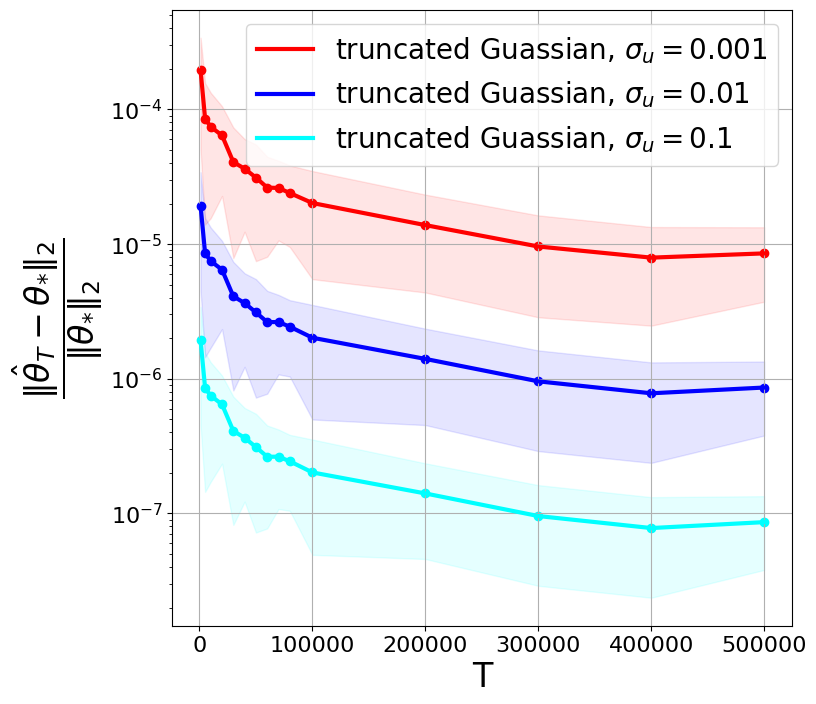

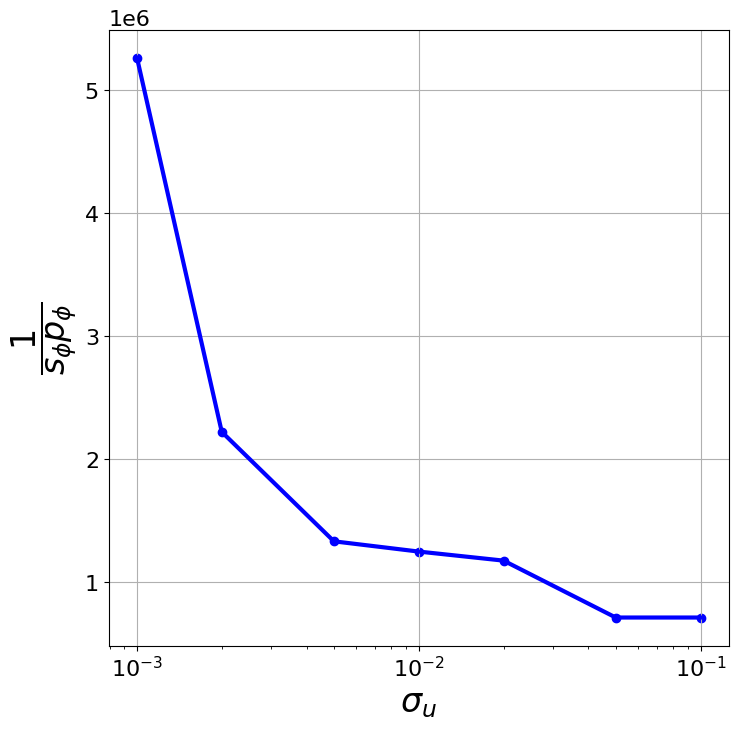

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

normalize = True
log_scale_x = False
log_scale_y = True
separate = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1


colors = ['red', 'blue', 'cyan', 'black',  'red', 'magenta', 'red']

time_hor_ = [1, 1000, 5000]
time_hor_.extend(range(10000, 90000, 10000))
time_hor_.extend(range(100000, 500002, 100000))


sigma_u_list = [1e-03, 0.002, 0.005, 1e-02, 0.02, 0.05, 1e-01]
sp_list = [1.90e-07, 4.50e-07, 7.50e-07, 8.00e-07, 8.50e-07, 1.4e-06, 1.4e-06]

linewidth_ = 3.0
alpha_ = 0.1

if separate:
  fig = plt.figure(figsize=(8, 8))
  # --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
  # ------------------------------------------------------------------------------------------------------------------------------------------
  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.001, 1000.0]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.001, 1000.0]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{u}=0.001$'
  plt.plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
  plt.scatter(time_list[1:], points[1:], color=colors[0], marker='o')
  plt.fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.01, 100.0]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.01, 100.0]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{u}=0.01$'
  plt.plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
  plt.scatter(time_list[1:], points[1:], color=colors[1], marker='o')
  plt.fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 10.0]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 10.0]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{u}=0.1$'
  plt.plot(time_list[1:], points[1:], color=colors[2], label=label1, linewidth=linewidth_)
  plt.scatter(time_list[1:], points[1:], color=colors[2], marker='o')
  plt.fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[2], alpha=alpha_)

  if log_scale_x:
    plt.xscale('log')
  if log_scale_y:
    plt.yscale('log')
  plt.xlabel('T')
  if normalize:
    plt.ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
  else:
    plt.ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')
  plt.legend()

  fig = plt.figure(figsize=(8, 8))
  plt.plot(sigma_u_list, 1/np.array(sp_list), color=colors[1], label=label1, linewidth=linewidth_)
  plt.scatter(sigma_u_list, 1/np.array(sp_list), color=colors[1], marker='o')
  plt.xlabel('$\sigma_{u}$')
  plt.ylabel('$\dfrac{1}{s_{\phi}p_{\phi}}$')
  plt.xscale('log')


else:
  fig, axs = plt.subplots(1, 2, figsize=(20, 8))
  plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)   # wspace: space between subplots in a row
  # --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
  # ------------------------------------------------------------------------------------------------------------------------------------------
  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.001, 1000.0]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.001, 1000.0]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{u}=0.001$'
  axs[0].plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
  axs[0].scatter(time_list[1:], points[1:], color=colors[0], marker='o')
  axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.01, 100.0]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.01, 100.0]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{u}=0.01$'
  axs[0].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
  axs[0].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
  axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 10.0]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 10.0]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{u}=0.1$'
  axs[0].plot(time_list[1:], points[1:], color=colors[2], label=label1, linewidth=linewidth_)
  axs[0].scatter(time_list[1:], points[1:], color=colors[2], marker='o')
  axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[2], alpha=alpha_)

  if log_scale_x:
    axs[0].set_xscale('log')
  if log_scale_y:
    axs[0].set_yscale('log')
  axs[0].set_xlabel('T')
  if normalize:
    axs[0].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
  else:
    axs[0].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')
  axs[0].legend()


  axs[1].plot(sigma_u_list, 1/np.array(sp_list), color=colors[1], label=label1, linewidth=linewidth_)
  axs[1].scatter(sigma_u_list, 1/np.array(sp_list), color=colors[1], marker='o')
  axs[1].set_xlabel('$\sigma_{u}$')
  axs[1].set_ylabel('$\dfrac{1}{s_{\phi}p_{\phi}}$')
  axs[1].set_xscale('log')
  # axs[1, 1].set_yscale('log')

plt.show()


disturbance

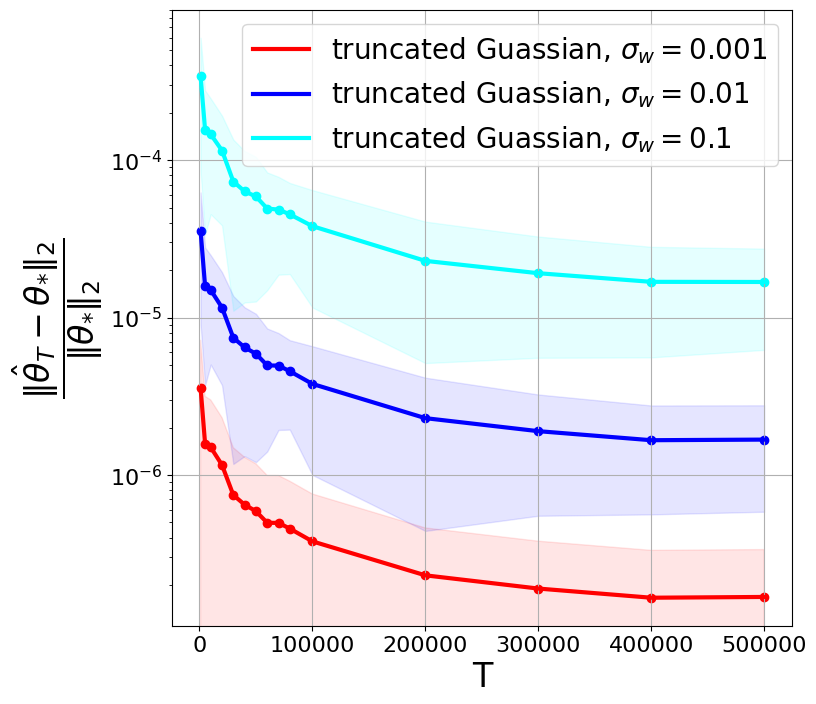

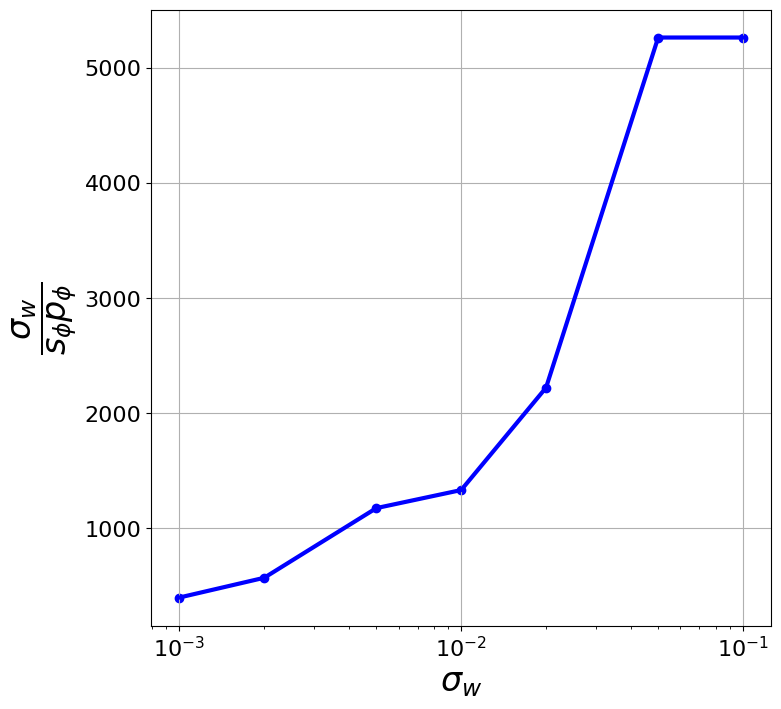

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

normalize = True
log_scale_x = False
log_scale_y = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1


colors = ['red', 'blue', 'cyan', 'black',  'red', 'magenta', 'red']

linewidth_ = 3.0
alpha_ = 0.1

time_hor_ = [1, 1000, 5000]
time_hor_.extend(range(10000, 90000, 10000))
time_hor_.extend(range(100000, 500002, 100000))


sigma_w_list = [1e-03, 0.002, 0.005, 1e-02, 0.02, 0.05, 1e-01]
sp_list = [2.5e-06, 3.50e-06, 4.25e-06, 7.50e-06, 9.00e-06, 9.50e-06, 1.90e-05]

if separate:
  fig = plt.figure(figsize=(8, 8))
  # --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
  # ------------------------------------------------------------------------------------------------------------------------------------------
  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  name2 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{w}=0.001$'
  plt.plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
  plt.scatter(time_list[1:], points[1:], color=colors[0], marker='o')
  plt.fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.01, 100.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.01, 100.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{w}=0.01$'
  plt.plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
  plt.scatter(time_list[1:], points[1:], color=colors[1], marker='o')
  plt.fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.1, 10.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.1, 10.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{w}=0.1$'
  plt.plot(time_list[1:], points[1:], color=colors[2], label=label1, linewidth=linewidth_)
  plt.scatter(time_list[1:], points[1:], color=colors[2], marker='o')
  plt.fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[2], alpha=alpha_)

  if log_scale_x:
    plt.xscale('log')
  if log_scale_y:
    plt.yscale('log')
  plt.xlabel('T')
  if normalize:
    plt.ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
  else:
    plt.ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')
  plt.legend()

  fig = plt.figure(figsize=(8, 8))
  plt.plot(sigma_w_list, np.array(sigma_w_list)/np.array(sp_list), color=colors[1], label=label1, linewidth=linewidth_)
  plt.scatter(sigma_w_list, np.array(sigma_w_list)/np.array(sp_list), color=colors[1], marker='o')
  plt.xlabel('$\sigma_{w}$')
  plt.ylabel('$\dfrac{\sigma_{w}}{s_{\phi}p_{\phi}}$')
  plt.xscale('log')
else:

  fig, axs = plt.subplots(1, 2, figsize=(20, 8))
  plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)   # wspace: space between subplots in a row
  # --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
  # ------------------------------------------------------------------------------------------------------------------------------------------
  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  name2 = 'lse_data1_w_trunc_guass_[0.0, 0.001, 1000.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{w}=0.001$'
  axs[0].plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
  axs[0].scatter(time_list[1:], points[1:], color=colors[0], marker='o')
  axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.01, 100.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.01, 100.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{w}=0.01$'
  axs[0].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
  axs[0].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
  axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

  name1 = 'lse_data1_w_trunc_guass_[0.0, 0.1, 10.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  name2 = 'lse_data2_w_trunc_guass_[0.0, 0.1, 10.0]_u_trunc_guass_[0.0, 0.1, 1]_[1].csv'
  time_list = time_hor_
  mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
  std_theta_hat_list = np.loadtxt(name2, delimiter=',')
  points = []
  errors = []
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
  label1 = 'truncated Guassian, $\sigma_{w}=0.1$'
  axs[0].plot(time_list[1:], points[1:], color=colors[2], label=label1, linewidth=linewidth_)
  axs[0].scatter(time_list[1:], points[1:], color=colors[2], marker='o')
  axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[2], alpha=alpha_)

  if log_scale_x:
    axs[0].set_xscale('log')
  if log_scale_y:
    axs[0].set_yscale('log')
  axs[0].set_xlabel('T')
  if normalize:
    axs[0].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
  else:
    axs[0].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')
  axs[0].legend()

  axs[1].plot(sigma_w_list, np.array(sigma_w_list)/np.array(sp_list), color=colors[1], label=label1, linewidth=linewidth_)
  axs[1].scatter(sigma_w_list, np.array(sigma_w_list)/np.array(sp_list), color=colors[1], marker='o')
  axs[1].set_xlabel('$\sigma_{w}$')
  axs[1].set_ylabel('$\dfrac{\sigma_{w}}{s_{\phi}p_{\phi}}$')
  axs[1].set_xscale('log')
  # axs[1, 1].set_yscale('log')

plt.show()


------------------------LSE Estimation Error Plots---------------------


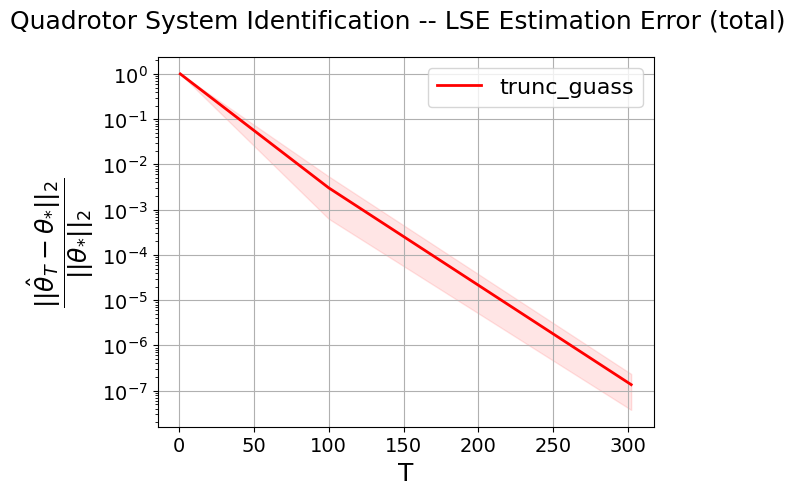

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

linewidth_ = 2.0
alpha_ = 0.1

log_scale = True
separate = False   # True means plot the individual error and total error in the same figure
normalize = True   # True means normalize the individual error when plotting

def plot_lse(mean_theta_hat_list, std_theta_hat_list, ground_truth, time_hor):

  time_hor_ = np.array(time_hor)

  points = []
  errors = []
  c0 = 1
  if normalize:
    c0 = np.linalg.norm(ground_truth)
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c0)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c0)

  kxs = [0, 1, 2]
  ix = [0, 0, 0]
  iy = [0, 1, 2]

  # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  # plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)   # wspace: space between subplots in a row

  # for i in range(len(kxs)):

  #   points_ = []
  #   error_ = []

  #   c = 1
  #   if normalize and ground_truth[kxs[i]] != 0.0:
  #     c = abs(ground_truth[kxs[i]])

  #   for j in range(len(mean_theta_hat_list)):
  #     points_.append(mean_theta_hat_list[j][kxs[i]].item() / c)
  #     error_.append(std_theta_hat_list[j][kxs[i]].item() / c)

  #   axs[iy[i]].plot(time_hor_, points_, '-', color='blue', label=disturbance, linewidth=linewidth_)
  #   axs[iy[i]].fill_between(time_hor_, np.array(points_) - np.array(error_), np.array(points_) + np.array(error_), color='blue', alpha=alpha_)
  #   # axs[ix[i], iy[i]].set_xticks([1, 5000, 10000])

  # if normalize:
  #   axs[0].set_xlabel('T')
  #   axs[0].set_ylabel('$\\dfrac{|\hat{\\theta}_{T}^{1} - \\theta_{*}^{1}|}{|\\theta_{*}^{1}|}$')
  #   axs[1].set_xlabel('T')
  #   axs[1].set_ylabel('$\\dfrac{|\hat{\\theta}_{T}^{2} - \\theta_{*}^{2}|}{|\\theta_{*}^{2}|}$')
  #   axs[2].set_xlabel('T')
  #   axs[2].set_ylabel('$\\dfrac{|\hat{\\theta}_{T}^{3} - \\theta_{*}^{3}|}{|\\theta_{*}^{3}|}$')
  # else:
  #   axs[0].set_xlabel('T')
  #   axs[0].set_ylabel('$|\hat{\\theta}_{T}^{1} - \\theta_{*}^{1}|$')
  #   axs[1].set_xlabel('T')
  #   axs[1].set_ylabel('$|\hat{\\theta}_{T}^{2} - \\theta_{*}^{2}|$')
  #   axs[2].set_xlabel('T')
  #   axs[2].set_ylabel('$|\hat{\\theta}_{T}^{3} - \\theta_{*}^{3}|$')

  # axs[0].legend()
  # axs[1].legend()
  # axs[2].legend()

  # if log_scale:
  #   axs[0].set_yscale('log')
  #   axs[1].set_yscale('log')
  #   axs[2].set_yscale('log')

  # fig.suptitle('Pendulum Identification -- LSE Estimation Error (individual parameters)')

  fig = plt.figure()
  plt.plot(time_hor_, points, color='red', label=disturbance, linewidth=linewidth_)
  plt.fill_between(time_hor_, np.array(points) - np.array(errors), np.array(points) + np.array(errors), color='red', alpha=alpha_)
  # plt.xticks([1, 5000, 10000])
  plt.xlabel('T')
  if normalize:
    plt.ylabel('$\\dfrac{||\hat{\\theta}_{T} - \\theta_{*}||_{2}}{||\\theta_{*}||_{2}}$')
  else:
    plt.ylabel('$||\hat{\\theta}_{T} - \\theta_{*}||_{2}$')
  plt.legend()
  fig.suptitle('Quadrotor System Identification -- LSE Estimation Error (total)')
  if log_scale:
    plt.yscale('log')

  plt.show()

print('------------------------LSE Estimation Error Plots---------------------')
plot_lse(mean_delta_theta_hat_list, std_delta_theta_hat_list, ground_truth, time_hor_)


In [ ]:
0.08718776400605169
-----------------------------------------------------------------------------------
0.0868436672080634
-----------------------------------------------------------------------------------
0.09771340194989796
-----------------------------------------------------------------------------------
1.7508933249108194
-----------------------------------------------------------------------------------
56.66949450890396
-----------------------------------------------------------------------------------
63.188532819273576
-----------------------------------------------------------------------------------
66.38053510512546
-----------------------------------------------------------------------------------
66.64041555328085
-----------------------------------------------------------------------------------
66.64774708544303
-----------------------------------------------------------------------------------
66.64782422009428
-----------------------------------------------------------------------------------

In [ ]:
s_phi = 0.2
p_phi = 0.2
b_phi = 66.64782422009428
m = 1
n_x = 1
n_phi = 3
sigma_w = 1
delta = 0.001

time_hor = 1000000
theo_bound = []
time_list = []
for k in range(time_hor):
  cc = b_phi/delta/s_phi/s_phi
  cond = (10/p_phi) * (np.log(1/delta) + 2*n_phi*np.log(10/p_phi) + n_phi*np.log(cc))
  if (k+1) >= cond:
    time_list.append(k+1)
    theo_bound_ = (90*sigma_w/p_phi) * np.sqrt((n_x + np.log(1/delta) + n_phi*np.log(10/p_phi) + n_phi*np.log(cc)) / ((k+1)*s_phi))
    theo_bound.append(theo_bound_)

# print(time_list)
# print(theo_bound)
# print(np.linalg.norm(np.array(ground_truth)))

disturbance = 'trunc_guass'
mult_w = [1, 1]
name1 = 'lse_theo_bound_8_' + 'w_' + disturbance + '_' + str(sigma_w) + '_' + 's_phi' '_' + str(s_phi) + '_' + 'p_phi' +  '_' + str(p_phi) +  '_' + 'delta' +   '_' + str(delta) + '.csv'
name2 = 'lse_theo_bound_9_' + 'w_' + disturbance + '_' + str(sigma_w) + '_' + 's_phi' '_' + str(s_phi) + '_' + 'p_phi' +  '_' + str(p_phi) +  '_' + 'delta' +   '_' + str(delta) + '.csv'
np.savetxt(name1, np.array(time_list), delimiter = ",")
np.savetxt(name2, np.array(theo_bound), delimiter = ",")

# Impact of increasing w_max on performance of LSE with truncated gaussian disturbnce

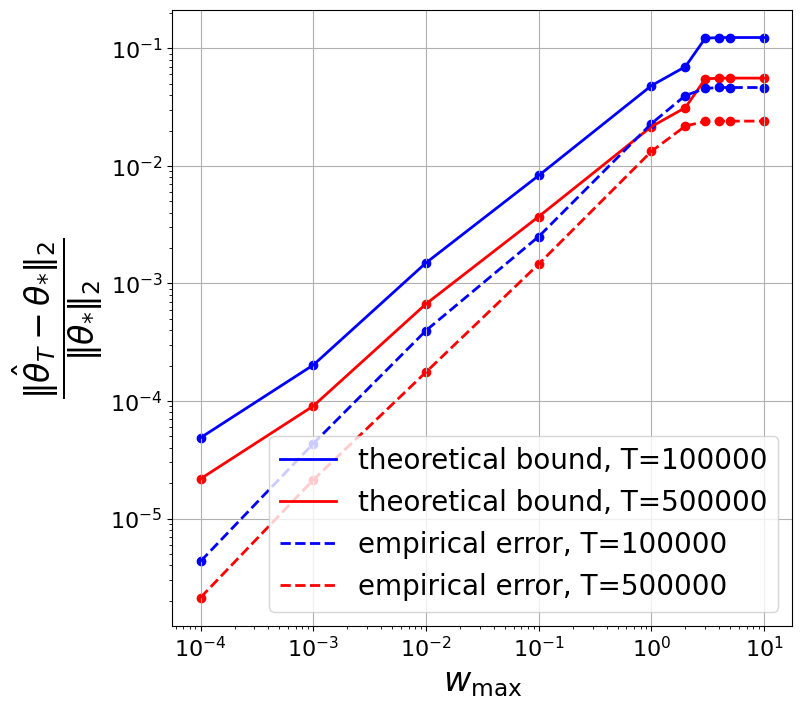

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

normalize = True
log_scale_x = True
log_scale_y = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1


colors = ['blue', 'blue', 'red', 'pink', 'red', 'magenta', 'red']

linewidth_ = 2.0
alpha_ = 0.1

fig = plt.figure(figsize=(8, 8))
# --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------

w_max_list = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 10]
sigma_w_list = [5.7741e-05,    5.7741e-04,    0.0058,    0.0577,    0.5396,    0.8796,    0.9866,    0.9995,    1.0000,    1.0000]
_list = w_max_list
# ------------------------------------------------------------------------------------------------------------------------------------------

delta = 0.001

name1 = 'lse_theo_bound_8_w_trunc_guass_5.7741e-05_s_phi_0.0005_p_phi_0.65_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_5.7741e-05_s_phi_0.0005_p_phi_0.65_delta_0.001.csv'
time_list_1 = np.loadtxt(name1, delimiter=',')
theo_bound_1 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.00057741_s_phi_0.005_p_phi_0.45_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.00057741_s_phi_0.005_p_phi_0.45_delta_0.001.csv'
time_list_2 = np.loadtxt(name1, delimiter=',')
theo_bound_2 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.0057741_s_phi_0.006_p_phi_0.55_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.0057741_s_phi_0.006_p_phi_0.55_delta_0.001.csv'
time_list_3 = np.loadtxt(name1, delimiter=',')
theo_bound_3 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.0577_s_phi_0.02_p_phi_0.55_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.0577_s_phi_0.02_p_phi_0.55_delta_0.001.csv'
time_list_4 = np.loadtxt(name1, delimiter=',')
theo_bound_4 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.5396_s_phi_0.1_p_phi_0.4_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.5396_s_phi_0.1_p_phi_0.4_delta_0.001.csv'
time_list_5 = np.loadtxt(name1, delimiter=',')
theo_bound_5 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.8796_s_phi_0.1_p_phi_0.45_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.8796_s_phi_0.1_p_phi_0.45_delta_0.001.csv'
time_list_6 = np.loadtxt(name1, delimiter=',')
theo_bound_6 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.9866_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.9866_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
time_list_7 = np.loadtxt(name1, delimiter=',')
theo_bound_7 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.9995_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.9995_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
time_list_8 = np.loadtxt(name1, delimiter=',')
theo_bound_8 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_1_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_1_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
time_list_9 = np.loadtxt(name1, delimiter=',')
theo_bound_9 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_1_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_1_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
time_list_10 = np.loadtxt(name1, delimiter=',')
theo_bound_10 = np.loadtxt(name2, delimiter=',')/c_norm

# print(time_list_1[0])
# print(time_list_2[0])
# print(time_list_3[0])
# print(time_list_4[0])

theo_bound_list_1 = []
theo_bound_list_2 = []
theo_bound_list_3 = []
T1 = 10000-1250
T2 = 100000-1250
T3 = 500000-1250
theo_bound_list_1.append(theo_bound_1[T1])
theo_bound_list_1.append(theo_bound_2[T1])
theo_bound_list_1.append(theo_bound_3[T1])
theo_bound_list_1.append(theo_bound_4[T1])
theo_bound_list_1.append(theo_bound_5[T1])
theo_bound_list_1.append(theo_bound_6[T1])
theo_bound_list_1.append(theo_bound_7[T1])
theo_bound_list_1.append(theo_bound_8[T1])
theo_bound_list_1.append(theo_bound_9[T1])
theo_bound_list_1.append(theo_bound_10[T1])

theo_bound_list_2.append(theo_bound_1[T2])
theo_bound_list_2.append(theo_bound_2[T2])
theo_bound_list_2.append(theo_bound_3[T2])
theo_bound_list_2.append(theo_bound_4[T2])
theo_bound_list_2.append(theo_bound_5[T2])
theo_bound_list_2.append(theo_bound_6[T2])
theo_bound_list_2.append(theo_bound_7[T2])
theo_bound_list_2.append(theo_bound_8[T2])
theo_bound_list_2.append(theo_bound_9[T2])
theo_bound_list_2.append(theo_bound_10[T2])

theo_bound_list_3.append(theo_bound_1[T3])
theo_bound_list_3.append(theo_bound_2[T3])
theo_bound_list_3.append(theo_bound_3[T3])
theo_bound_list_3.append(theo_bound_4[T3])
theo_bound_list_3.append(theo_bound_5[T3])
theo_bound_list_3.append(theo_bound_6[T3])
theo_bound_list_3.append(theo_bound_7[T3])
theo_bound_list_3.append(theo_bound_8[T3])
theo_bound_list_3.append(theo_bound_9[T3])
theo_bound_list_3.append(theo_bound_10[T3])

label1 = 'theoretical bound, T=10000'
label2 = 'theoretical bound, T=100000'
label3 = 'theoretical bound, T=500000'
# plt.plot(_list, theo_bound_list_1, color=colors[0], label=label1, linewidth=linewidth_)
plt.plot(_list, theo_bound_list_2, color=colors[1], label=label2, linewidth=linewidth_)
plt.scatter(_list, theo_bound_list_2, color=colors[1], marker='o')
plt.plot(_list, theo_bound_list_3, color=colors[2], label=label3, linewidth=linewidth_)
plt.scatter(_list, theo_bound_list_3, color=colors[2], marker='o')


time_hor_ = [1, 1000, 5000]
time_hor_.extend(range(10000, 90000, 10000))
time_hor_.extend(range(100000, max_time_hor, 100000))
time_list = time_hor_

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'

mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_1 = []
errors_1 = []
for j in range(len(mean_theta_hat_list)):
  points_1.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_1.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_2 = []
errors_2 = []
for j in range(len(mean_theta_hat_list)):
  points_2.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_2.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)


name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_3 = []
errors_3 = []
for j in range(len(mean_theta_hat_list)):
  points_3.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_3.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.1]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.1]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_4 = []
errors_4 = []
for j in range(len(mean_theta_hat_list)):
  points_4.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_4.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 1]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 1]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_5 = []
errors_5 = []
for j in range(len(mean_theta_hat_list)):
  points_5.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_5.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 2]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 2]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_6 = []
errors_6 = []
for j in range(len(mean_theta_hat_list)):
  points_6.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_6.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 3]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 3]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_7 = []
errors_7 = []
for j in range(len(mean_theta_hat_list)):
  points_7.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_7.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 4]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 4]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_8 = []
errors_8 = []
for j in range(len(mean_theta_hat_list)):
  points_8.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_8.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 5]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 5]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_9 = []
errors_9 = []
for j in range(len(mean_theta_hat_list)):
  points_9.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_9.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 10]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 10]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points_10 = []
errors_10 = []
for j in range(len(mean_theta_hat_list)):
  points_10.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors_10.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)


emp_bound_list_1 = []
emp_bound_list_2 = []
emp_bound_list_3 = []
error_bound_list_1 = []
error_bound_list_2 = []
error_bound_list_3 = []
T1 = 3
T2 = 11
T3 = 15
emp_bound_list_1.append(points_1[T1])
emp_bound_list_1.append(points_2[T1])
emp_bound_list_1.append(points_3[T1])
emp_bound_list_1.append(points_4[T1])
emp_bound_list_1.append(points_5[T1])
emp_bound_list_1.append(points_6[T1])
emp_bound_list_1.append(points_7[T1])
emp_bound_list_1.append(points_8[T1])
emp_bound_list_1.append(points_9[T1])
emp_bound_list_1.append(points_10[T1])
error_bound_list_1.append(errors_1[T1])
error_bound_list_1.append(errors_2[T1])
error_bound_list_1.append(errors_3[T1])
error_bound_list_1.append(errors_4[T1])
error_bound_list_1.append(errors_5[T1])
error_bound_list_1.append(errors_6[T1])
error_bound_list_1.append(errors_7[T1])
error_bound_list_1.append(errors_8[T1])
error_bound_list_1.append(errors_9[T1])
error_bound_list_1.append(errors_10[T1])
# --------------------------------------------------------------------------
emp_bound_list_2.append(points_1[T2])
emp_bound_list_2.append(points_2[T2])
emp_bound_list_2.append(points_3[T2])
emp_bound_list_2.append(points_4[T2])
emp_bound_list_2.append(points_5[T2])
emp_bound_list_2.append(points_6[T2])
emp_bound_list_2.append(points_7[T2])
emp_bound_list_2.append(points_8[T2])
emp_bound_list_2.append(points_9[T2])
emp_bound_list_2.append(points_10[T2])
error_bound_list_2.append(errors_1[T2])
error_bound_list_2.append(errors_2[T2])
error_bound_list_2.append(errors_3[T2])
error_bound_list_2.append(errors_4[T2])
error_bound_list_2.append(errors_5[T2])
error_bound_list_2.append(errors_6[T2])
error_bound_list_2.append(errors_7[T2])
error_bound_list_2.append(errors_8[T2])
error_bound_list_2.append(errors_9[T2])
error_bound_list_2.append(errors_10[T2])
# --------------------------------------------------------------------------
emp_bound_list_3.append(points_1[T3])
emp_bound_list_3.append(points_2[T3])
emp_bound_list_3.append(points_3[T3])
emp_bound_list_3.append(points_4[T3])
emp_bound_list_3.append(points_5[T3])
emp_bound_list_3.append(points_6[T3])
emp_bound_list_3.append(points_7[T3])
emp_bound_list_3.append(points_8[T3])
emp_bound_list_3.append(points_9[T3])
emp_bound_list_3.append(points_10[T3])
error_bound_list_3.append(errors_1[T3])
error_bound_list_3.append(errors_2[T3])
error_bound_list_3.append(errors_3[T3])
error_bound_list_3.append(errors_4[T3])
error_bound_list_3.append(errors_5[T3])
error_bound_list_3.append(errors_6[T3])
error_bound_list_3.append(errors_7[T3])
error_bound_list_3.append(errors_8[T3])
error_bound_list_3.append(errors_9[T3])
error_bound_list_3.append(errors_10[T3])


label1 = 'empirical error, T=10000'
label2 = 'empirical error, T=100000'
label3 = 'empirical error, T=500000'
# plt.plot(_list, emp_bound_list_1, '--', color=colors[0], label=label1, linewidth=linewidth_)
plt.plot(_list, emp_bound_list_2, '--', color=colors[1], label=label2, linewidth=linewidth_)
plt.scatter(_list, emp_bound_list_2, color=colors[1], marker='o')
plt.plot(_list, emp_bound_list_3, '--', color=colors[2], label=label3, linewidth=linewidth_)
plt.scatter(_list, emp_bound_list_3, color=colors[2], marker='o')

alpha_ = 0.1
# # plt.fill_between(_list, np.array(emp_bound_list_1) - np.array(error_bound_list_1), np.array(emp_bound_list_1) + np.array(error_bound_list_1), color=colors[0], alpha=alpha_)
# plt.fill_between(_list, np.array(emp_bound_list_2) - np.array(error_bound_list_2), np.array(emp_bound_list_2) + np.array(error_bound_list_2), color=colors[1], alpha=alpha_)
# plt.fill_between(_list, np.array(emp_bound_list_3) - np.array(error_bound_list_3), np.array(emp_bound_list_3) + np.array(error_bound_list_3), color=colors[2], alpha=alpha_)



if log_scale_x:
  plt.xscale('log')
if log_scale_y:
  plt.yscale('log')

plt.xlabel('$w_{\max}$')
if normalize:
  plt.ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  plt.ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

plt.legend()


# plt.title('Pendulum Example, LSE with Truncated Gaussian Disturbance')
# plt.title('Pendulum Example, LSE Theoretical Bound w.p. at least $0.997$')
plt.show()



# Impact of increasing sigma_w on performance of LSE with truncated gaussian and unform disturbnce

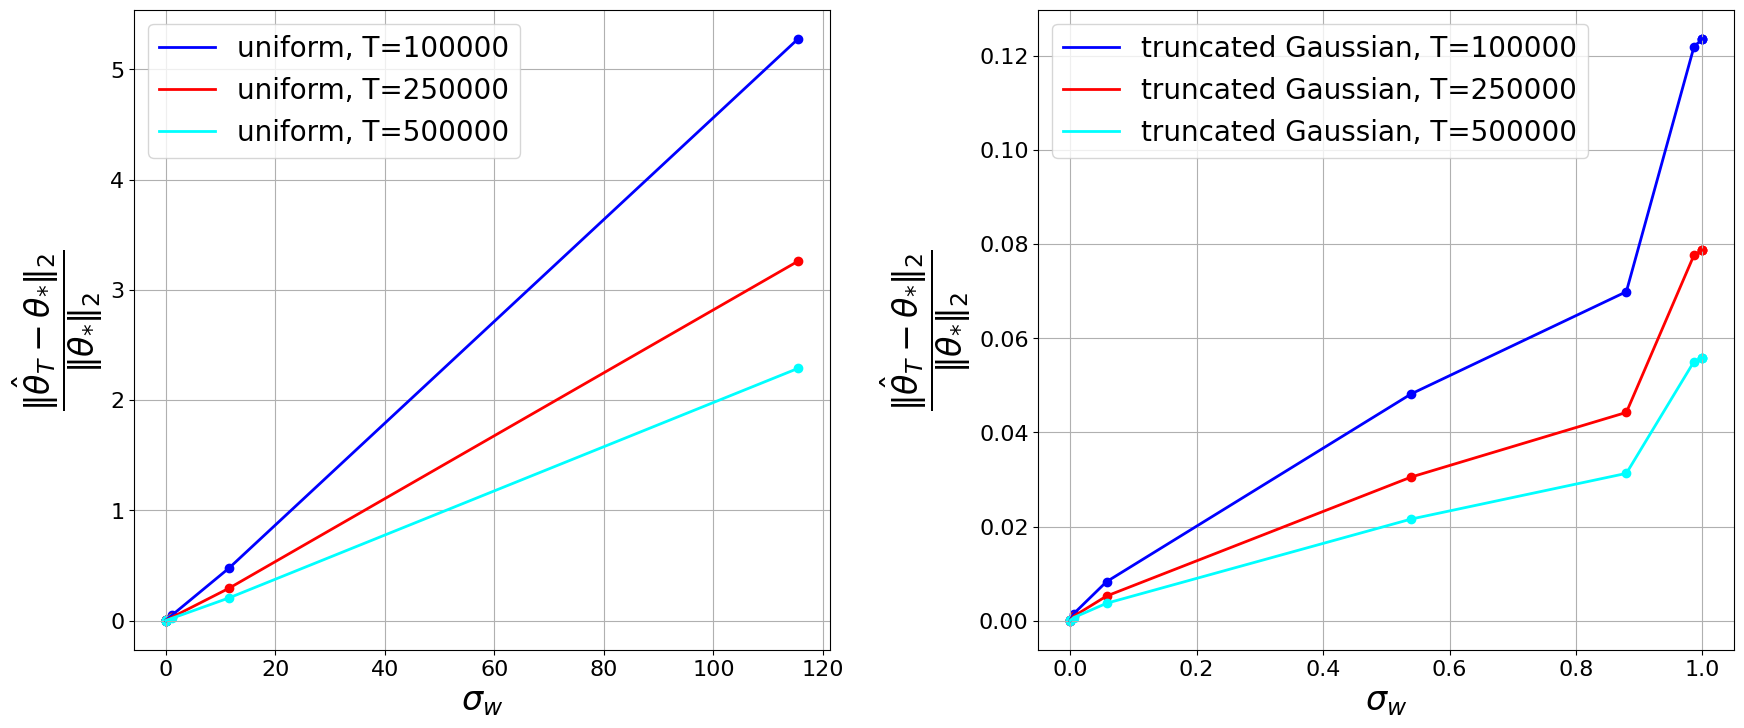

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

normalize = True
log_scale_x = False
log_scale_y = False

linewidth_ = 2.0
alpha_ = 0.1

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)   # wspace: space between subplots in a row

colors = ['blue', 'red', 'cyan', 'pink', 'magenta', 'orange', 'green', 'yellow', 'gray', 'brown', 'black']

# -------------------------------------------------------------------------------------------------------------------------------- uniform
w_max_list = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
sigma_w_list = (w_max_list * 2)/np.sqrt(3)
_list = sigma_w_list


name1 = 'lse_theo_bound_8_w_uniform_5.773502691896258e-05_s_phi_0.0005_p_phi_0.5_delta_0.01.csv'
name2 = 'lse_theo_bound_9_w_uniform_5.773502691896258e-05_s_phi_0.0005_p_phi_0.5_delta_0.01.csv'
time_list_1 = np.loadtxt(name1, delimiter=',')
theo_bound_1 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_uniform_0.0005773502691896257_s_phi_0.006_p_phi_0.4_delta_0.01.csv'
name2 = 'lse_theo_bound_9_w_uniform_0.0005773502691896257_s_phi_0.006_p_phi_0.4_delta_0.01.csv'
time_list_2 = np.loadtxt(name1, delimiter=',')
theo_bound_2 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_uniform_0.005773502691896258_s_phi_0.006_p_phi_0.3_delta_0.01.csv'
name2 = 'lse_theo_bound_9_w_uniform_0.005773502691896258_s_phi_0.006_p_phi_0.3_delta_0.01.csv'
time_list_3 = np.loadtxt(name1, delimiter=',')
theo_bound_3 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_uniform_0.05773502691896258_s_phi_0.04_p_phi_0.35_delta_0.01.csv'
name2 = 'lse_theo_bound_9_w_uniform_0.05773502691896258_s_phi_0.04_p_phi_0.35_delta_0.01.csv'
time_list_4 = np.loadtxt(name1, delimiter=',')
theo_bound_4 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_uniform_0.5773502691896257_s_phi_0.1_p_phi_0.4_delta_0.01.csv'
name2 = 'lse_theo_bound_9_w_uniform_0.5773502691896257_s_phi_0.1_p_phi_0.4_delta_0.01.csv'
time_list_5 = np.loadtxt(name1, delimiter=',')
theo_bound_5 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_uniform_5.773502691896258_s_phi_0.2_p_phi_0.3_delta_0.01.csv'
name2 = 'lse_theo_bound_9_w_uniform_5.773502691896258_s_phi_0.2_p_phi_0.3_delta_0.01.csv'
time_list_6 = np.loadtxt(name1, delimiter=',')
theo_bound_6 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_uniform_57.735026918962575_s_phi_0.2_p_phi_0.3_delta_0.01.csv'
name2 = 'lse_theo_bound_9_w_uniform_57.735026918962575_s_phi_0.2_p_phi_0.3_delta_0.01.csv'
time_list_7 = np.loadtxt(name1, delimiter=',')
theo_bound_7 = np.loadtxt(name2, delimiter=',')/c_norm


theo_bound_list_1 = []
theo_bound_list_2 = []
theo_bound_list_3 = []
T1 = 100000-9999
T2 = 250000-10000
T3 = 500000-10000
theo_bound_list_1.append(theo_bound_1[T1])
theo_bound_list_1.append(theo_bound_2[T1])
theo_bound_list_1.append(theo_bound_3[T1])
theo_bound_list_1.append(theo_bound_4[T1])
theo_bound_list_1.append(theo_bound_5[T1])
theo_bound_list_1.append(theo_bound_6[T1])
theo_bound_list_1.append(theo_bound_7[T1])

theo_bound_list_2.append(theo_bound_1[T2])
theo_bound_list_2.append(theo_bound_2[T2])
theo_bound_list_2.append(theo_bound_3[T2])
theo_bound_list_2.append(theo_bound_4[T2])
theo_bound_list_2.append(theo_bound_5[T2])
theo_bound_list_2.append(theo_bound_6[T2])
theo_bound_list_2.append(theo_bound_7[T2])

theo_bound_list_3.append(theo_bound_1[T3])
theo_bound_list_3.append(theo_bound_2[T3])
theo_bound_list_3.append(theo_bound_3[T3])
theo_bound_list_3.append(theo_bound_4[T3])
theo_bound_list_3.append(theo_bound_5[T3])
theo_bound_list_3.append(theo_bound_6[T3])
theo_bound_list_3.append(theo_bound_7[T3])

label1 = 'uniform, T=100000'
label2 = 'uniform, T=250000'
label3 = 'uniform, T=500000'
axs[0].plot(_list, theo_bound_list_1, color=colors[0], label=label1, linewidth=linewidth_)
axs[0].scatter(_list, theo_bound_list_1, color=colors[0], marker='o')
axs[0].plot(_list, theo_bound_list_2, color=colors[1], label=label2, linewidth=linewidth_)
axs[0].scatter(_list, theo_bound_list_2, color=colors[1], marker='o')
axs[0].plot(_list, theo_bound_list_3, color=colors[2], label=label3, linewidth=linewidth_)
axs[0].scatter(_list, theo_bound_list_3, color=colors[2], marker='o')

if log_scale_x:
  axs[0].set_xscale('log')
if log_scale_y:
  axs[0].set_yscale('log')


axs[0].set_xlabel('$\sigma_{w}$')
if normalize:
  axs[0].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[0].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

axs[0].legend()

# ----------------------------------------------------------------------------------------------------------------- truncated Gaussian
w_max_list = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 10]
sigma_w_list = [5.7741e-05,    5.7741e-04,    0.0058,    0.0577,    0.5396,    0.8796,    0.9866,    0.9995,    1.0000,    1.0000]
_list = sigma_w_list

name1 = 'lse_theo_bound_8_w_trunc_guass_5.7741e-05_s_phi_0.0005_p_phi_0.65_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_5.7741e-05_s_phi_0.0005_p_phi_0.65_delta_0.001.csv'
time_list_1 = np.loadtxt(name1, delimiter=',')
theo_bound_1 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.00057741_s_phi_0.005_p_phi_0.45_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.00057741_s_phi_0.005_p_phi_0.45_delta_0.001.csv'
time_list_2 = np.loadtxt(name1, delimiter=',')
theo_bound_2 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.0057741_s_phi_0.006_p_phi_0.55_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.0057741_s_phi_0.006_p_phi_0.55_delta_0.001.csv'
time_list_3 = np.loadtxt(name1, delimiter=',')
theo_bound_3 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.0577_s_phi_0.02_p_phi_0.55_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.0577_s_phi_0.02_p_phi_0.55_delta_0.001.csv'
time_list_4 = np.loadtxt(name1, delimiter=',')
theo_bound_4 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.5396_s_phi_0.1_p_phi_0.4_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.5396_s_phi_0.1_p_phi_0.4_delta_0.001.csv'
time_list_5 = np.loadtxt(name1, delimiter=',')
theo_bound_5 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.8796_s_phi_0.1_p_phi_0.45_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.8796_s_phi_0.1_p_phi_0.45_delta_0.001.csv'
time_list_6 = np.loadtxt(name1, delimiter=',')
theo_bound_6 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.9866_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.9866_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
time_list_7 = np.loadtxt(name1, delimiter=',')
theo_bound_7 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_0.9995_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_0.9995_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
time_list_8 = np.loadtxt(name1, delimiter=',')
theo_bound_8 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_1_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_1_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
time_list_9 = np.loadtxt(name1, delimiter=',')
theo_bound_9 = np.loadtxt(name2, delimiter=',')/c_norm

name1 = 'lse_theo_bound_8_w_trunc_guass_1_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
name2 = 'lse_theo_bound_9_w_trunc_guass_1_s_phi_0.2_p_phi_0.2_delta_0.001.csv'
time_list_10 = np.loadtxt(name1, delimiter=',')
theo_bound_10 = np.loadtxt(name2, delimiter=',')/c_norm

theo_bound_list_1 = []
theo_bound_list_2 = []
theo_bound_list_3 = []
T1 = 100000-1250
T2 = 250000-1250
T3 = 500000-1250
theo_bound_list_1.append(theo_bound_1[T1])
theo_bound_list_1.append(theo_bound_2[T1])
theo_bound_list_1.append(theo_bound_3[T1])
theo_bound_list_1.append(theo_bound_4[T1])
theo_bound_list_1.append(theo_bound_5[T1])
theo_bound_list_1.append(theo_bound_6[T1])
theo_bound_list_1.append(theo_bound_7[T1])
theo_bound_list_1.append(theo_bound_8[T1])
theo_bound_list_1.append(theo_bound_9[T1])
theo_bound_list_1.append(theo_bound_10[T1])

theo_bound_list_2.append(theo_bound_1[T2])
theo_bound_list_2.append(theo_bound_2[T2])
theo_bound_list_2.append(theo_bound_3[T2])
theo_bound_list_2.append(theo_bound_4[T2])
theo_bound_list_2.append(theo_bound_5[T2])
theo_bound_list_2.append(theo_bound_6[T2])
theo_bound_list_2.append(theo_bound_7[T2])
theo_bound_list_2.append(theo_bound_8[T2])
theo_bound_list_2.append(theo_bound_9[T2])
theo_bound_list_2.append(theo_bound_10[T2])

theo_bound_list_3.append(theo_bound_1[T3])
theo_bound_list_3.append(theo_bound_2[T3])
theo_bound_list_3.append(theo_bound_3[T3])
theo_bound_list_3.append(theo_bound_4[T3])
theo_bound_list_3.append(theo_bound_5[T3])
theo_bound_list_3.append(theo_bound_6[T3])
theo_bound_list_3.append(theo_bound_7[T3])
theo_bound_list_3.append(theo_bound_8[T3])
theo_bound_list_3.append(theo_bound_9[T3])
theo_bound_list_3.append(theo_bound_10[T3])

label1 = 'truncated Gaussian, T=100000'
label2 = 'truncated Gaussian, T=250000'
label3 = 'truncated Gaussian, T=500000'
axs[1].plot(_list, theo_bound_list_1, color=colors[0], label=label1, linewidth=linewidth_)
axs[1].scatter(_list, theo_bound_list_1, color=colors[0], marker='o')
axs[1].plot(_list, theo_bound_list_2, color=colors[1], label=label2, linewidth=linewidth_)
axs[1].scatter(_list, theo_bound_list_2, color=colors[1], marker='o')
axs[1].plot(_list, theo_bound_list_3, color=colors[2], label=label3, linewidth=linewidth_)
axs[1].scatter(_list, theo_bound_list_3, color=colors[2], marker='o')

if log_scale_x:
  axs[1].set_xscale('log')
if log_scale_y:
  axs[1].set_yscale('log')

axs[1].set_xlabel('$\sigma_{w}$')
if normalize:
  axs[1].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[1].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

axs[1].legend()

# fig.suptitle('Pendulum Example, LSE Theoretical Bound')
plt.show()


# plotting BMSB parameters with both uniform and truncated gaussian disrurbances

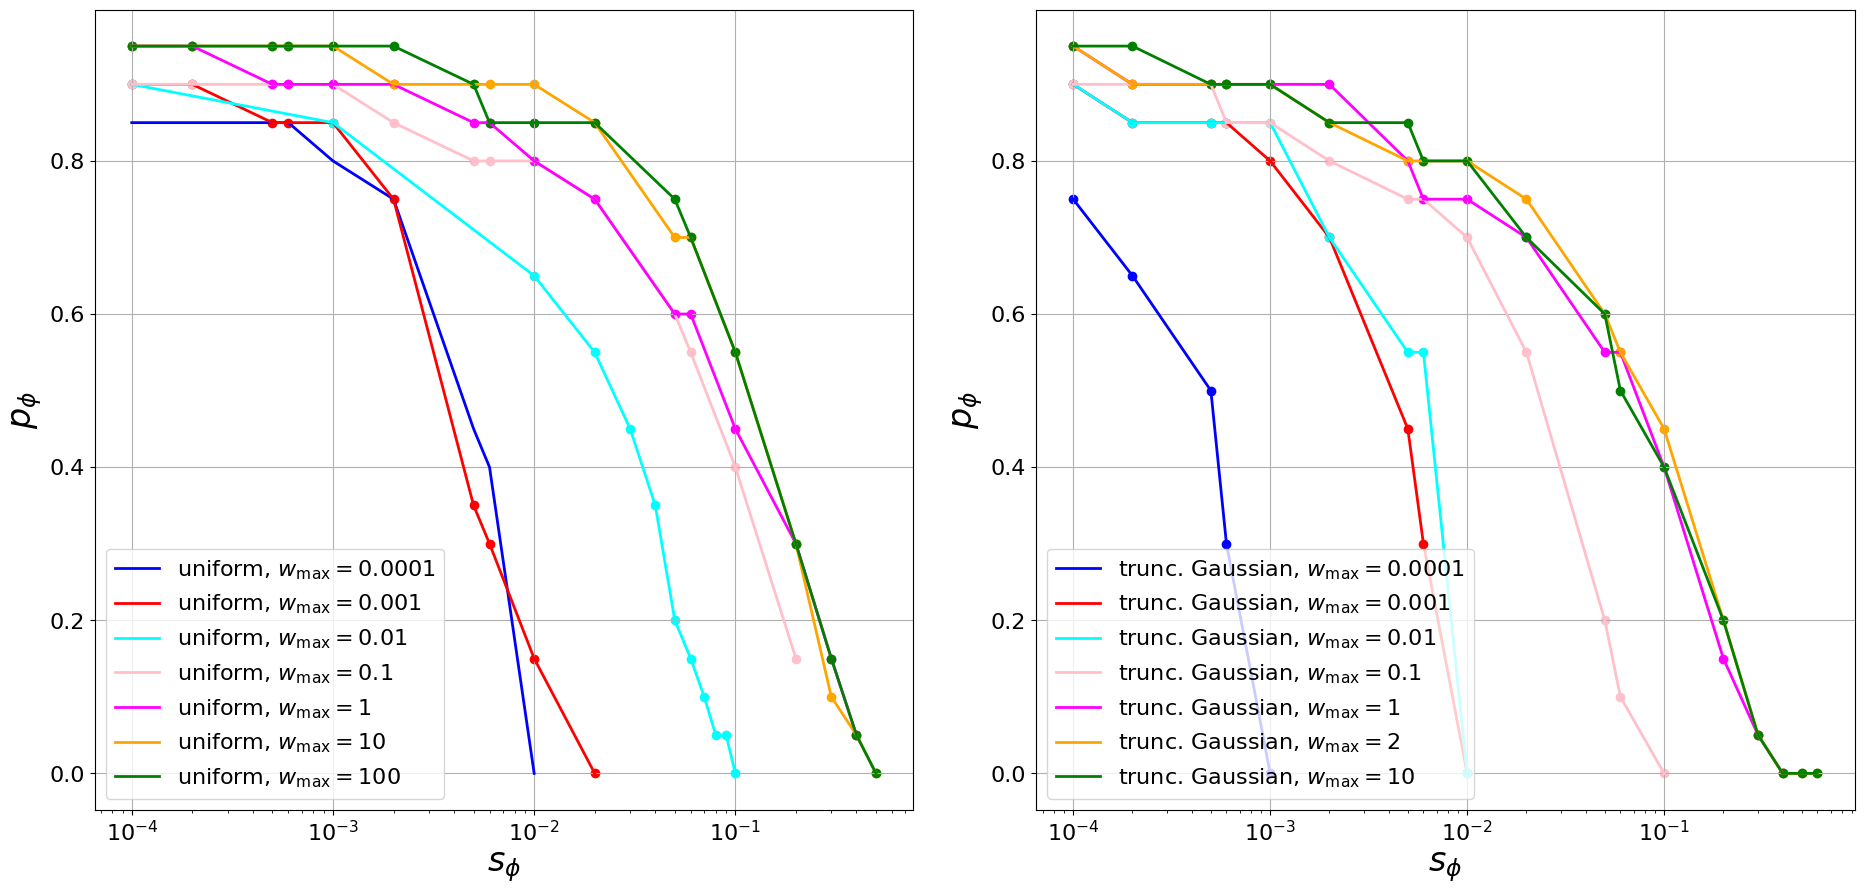

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

fig, axs = plt.subplots(1, 2, figsize=(22, 10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=0.4)   # wspace: space between subplots in a row

colors = ['blue', 'red', 'cyan', 'pink', 'magenta', 'orange', 'green', 'yellow', 'gray', 'brown', 'black']

# ----------------------------------------------------------------------------------------------------------------- truncated Gaussian
name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')
p_phi_1 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_2 = np.loadtxt(name1, delimiter=',')
prob_list_2 = np.loadtxt(name2, delimiter=',')
p_phi_2 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_3 = np.loadtxt(name1, delimiter=',')
prob_list_3 = np.loadtxt(name2, delimiter=',')
p_phi_3 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 0.1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 0.1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 0.1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_4 = np.loadtxt(name1, delimiter=',')
prob_list_4 = np.loadtxt(name2, delimiter=',')
p_phi_4 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 1]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_5 = np.loadtxt(name1, delimiter=',')
prob_list_5 = np.loadtxt(name2, delimiter=',')
p_phi_5 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 2]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 2]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 2]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_6 = np.loadtxt(name1, delimiter=',')
prob_list_6 = np.loadtxt(name2, delimiter=',')
p_phi_6 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 3]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 3]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 3]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_7 = np.loadtxt(name1, delimiter=',')
prob_list_7 = np.loadtxt(name2, delimiter=',')
p_phi_7 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 4]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 4]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 4]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_8 = np.loadtxt(name1, delimiter=',')
prob_list_8 = np.loadtxt(name2, delimiter=',')
p_phi_8 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 5]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 5]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 5]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_9 = np.loadtxt(name1, delimiter=',')
prob_list_9 = np.loadtxt(name2, delimiter=',')
p_phi_9 = np.loadtxt(name3, delimiter=',')

name1 = 'bmsb_data5_w_trunc_guass_[0.0, 1000, 10]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name2 = 'bmsb_data6_w_trunc_guass_[0.0, 1000, 10]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
name3 = 'bmsb_data7_w_trunc_guass_[0.0, 1000, 10]_u_trunc_guass_[0.0, 0.5, 1]_[1]_[1, 1].csv'
c_list_10 = np.loadtxt(name1, delimiter=',')
prob_list_10 = np.loadtxt(name2, delimiter=',')
p_phi_10 = np.loadtxt(name3, delimiter=',')


sigma_w = 0.00006 #5.7741e-05
label1 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
label1 = 'trunc. Gaussian, $w_{\max} = $' + str(0.0001)
axs[1].plot(c_list_1, 1-prob_list_1, color=colors[0], label=label1, linewidth=2)
axs[1].scatter(c_list_1, 1-prob_list_1, color=colors[0], marker='o')

sigma_w = 6e-4 # 5.7741e-04
label2 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
label2 = 'trunc. Gaussian, $w_{\max} = $' + str(0.001)
axs[1].plot(c_list_2, 1-prob_list_2, color=colors[1], label=label2, linewidth=2)
axs[1].scatter(c_list_2, 1-prob_list_2, color=colors[1], marker='o')

sigma_w = 0.006 # 0.0058
label3 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
label3 = 'trunc. Gaussian, $w_{\max} = $' + str(0.01)
axs[1].plot(c_list_3, 1-prob_list_3, color=colors[2], label=label3, linewidth=2)
axs[1].scatter(c_list_3, 1-prob_list_3, color=colors[2], marker='o')

sigma_w = 0.06 # 0.0577
label4 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
label4 = 'trunc. Gaussian, $w_{\max} = $' + str(0.1)
axs[1].plot(c_list_4, 1-prob_list_4, color=colors[3], label=label4, linewidth=2)
axs[1].scatter(c_list_4, 1-prob_list_4, color=colors[3], marker='o')

sigma_w = 0.54 # 0.53956
label5 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
label5 = 'trunc. Gaussian, $w_{\max} = $' + str(1)
axs[1].plot(c_list_5, 1-prob_list_5, color=colors[4], label=label5, linewidth=2)
axs[1].scatter(c_list_5, 1-prob_list_5, color=colors[4], marker='o')

sigma_w = 0.88 # 0.8796
label6 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
label6 = 'trunc. Gaussian, $w_{\max} = $' + str(2)
axs[1].plot(c_list_6, 1-prob_list_6, color=colors[5], label=label6, linewidth=2)
axs[1].scatter(c_list_6, 1-prob_list_6, color=colors[5], marker='o')

# sigma_w = 98 # 0.9866
# label7 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
# label7 = 'trunc. Gaussian, $w_{\max} = $' + str(3)
# axs[1].plot(c_list_7, 1-prob_list_7, color=colors[6], label=label7, linewidth=2)
# axs[1].scatter(c_list_7, 1-prob_list_7, color=colors[6], marker='o')

# sigma_w = 0.99 # 0.9866
# label8 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
# label8 = 'trunc. Gaussian, $w_{\max} = $' + str(4)
# axs[1].plot(c_list_8, 1-prob_list_8, color=colors[7], label=label8, linewidth=2)
# axs[1].scatter(c_list_8, 1-prob_list_8, color=colors[7], marker='o')

# sigma_w = 1 # 0.9866
# label9 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
# label9 = 'trunc. Gaussian, $w_{\max} = $' + str(5)
# axs[1].plot(c_list_9, 1-prob_list_9, color=colors[5], label=label9, linewidth=2)
# axs[1].scatter(c_list_9, 1-prob_list_9, color=colors[5], marker='o')

sigma_w = 1 # 0.9866
label10 = 'trunc. Gaussian, $\sigma_{w} = $' + str(sigma_w)
label10 = 'trunc. Gaussian, $w_{\max} = $' + str(10)
axs[1].plot(c_list_10, 1-prob_list_10, color=colors[6], label=label10, linewidth=2)
axs[1].scatter(c_list_10, 1-prob_list_10, color=colors[6], marker='o')

axs[1].set_xlabel('$s_{\phi}$')
axs[1].set_ylabel('$p_{\phi}$')
axs[1].legend()
axs[1].set_xscale('log')

# -------------------------------------------------------------------------------------------------------------------------------- uniform
name1 = 'bmsb_data3_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_1 = np.loadtxt(name1, delimiter=',')
prob_list_1 = np.loadtxt(name2, delimiter=',')

name1 = 'bmsb_data3_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_2 = np.loadtxt(name1, delimiter=',')
prob_list_2 = np.loadtxt(name2, delimiter=',')

name1 = 'bmsb_data1_w_uniform_[-100, 100]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data2_w_uniform_[-100, 100]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_3 = np.loadtxt(name1, delimiter=',')
prob_list_3 = np.loadtxt(name2, delimiter=',')

name1 = 'bmsb_data3_w_uniform_[-1000, 1000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-1000, 1000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_4 = np.loadtxt(name1, delimiter=',')
prob_list_4 = np.loadtxt(name2, delimiter=',')

name1 = 'bmsb_data3_w_uniform_[-10000, 10000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-10000, 10000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_5 = np.loadtxt(name1, delimiter=',')
prob_list_5 = np.loadtxt(name2, delimiter=',')

name1 = 'bmsb_data3_w_uniform_[-100000, 100000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-100000, 100000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_6 = np.loadtxt(name1, delimiter=',')
prob_list_6 = np.loadtxt(name2, delimiter=',')

name1 = 'bmsb_data3_w_uniform_[-1000000, 1000000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
name2 = 'bmsb_data4_w_uniform_[-1000000, 1000000]_u_uniform_[-0.5, 0.5]_[1]_[1, 1].csv'
c_list_7 = np.loadtxt(name1, delimiter=',')
prob_list_7 = np.loadtxt(name2, delimiter=',')

sigma_w = 0.001/np.sqrt(3)
sigma_w = 6e-4
label1 = 'uniform, $\sigma_{w} = $' + str(sigma_w)
label1 = 'uniform, $w_{\max} = $' + str(0.0001)
axs[0].plot(c_list_1, 1-prob_list_1, color=colors[0], label=label1, linewidth=2)

sigma_w = 0.01/np.sqrt(3)
sigma_w = 0.006
label2 = 'uniform, $\sigma_{w} = $' + str(sigma_w)
label2 = 'uniform, $w_{\max} = $' + str(0.001)
axs[0].plot(c_list_2, 1-prob_list_2, color=colors[1], label=label2, linewidth=2)
axs[0].scatter(c_list_2, 1-prob_list_2, color=colors[1], marker='o')

sigma_w = 0.1/np.sqrt(3)
sigma_w = 0.06
label3 = 'uniform, $\sigma_{w} = $' + str(sigma_w)
label3 = 'uniform, $w_{\max} = $' + str(0.01)
axs[0].plot(c_list_3[4:], 1-prob_list_3[4:], color=colors[2], label=label3, linewidth=2)
axs[0].scatter(c_list_3[4:], 1-prob_list_3[4:], color=colors[2], marker='o')


sigma_w = 1/np.sqrt(3)
sigma_w = 0.58
label4 = 'uniform, $\sigma_{w} = $' + str(sigma_w)
label4 = 'uniform, $w_{\max} = $' + str(0.1)
axs[0].plot(c_list_4, 1-prob_list_4, color=colors[3], label=label4, linewidth=2)
axs[0].scatter(c_list_4, 1-prob_list_4, color=colors[3], marker='o')

sigma_w = 10/np.sqrt(3)
sigma_w = 5.77
label5 = 'uniform, $\sigma_{w} = $' + str(sigma_w)
label5 = 'uniform, $w_{\max} = $' + str(1)
axs[0].plot(c_list_5, 1-prob_list_5, color=colors[4], label=label5, linewidth=2)
axs[0].scatter(c_list_5, 1-prob_list_5, color=colors[4], marker='o')

sigma_w = 100/np.sqrt(3)
sigma_w = 57.74
label6 = 'uniform, $\sigma_{w} = $' + str(sigma_w)
label6 = 'uniform, $w_{\max} = $' + str(10)
axs[0].plot(c_list_6, 1-prob_list_6, color=colors[5], label=label6, linewidth=2)
axs[0].scatter(c_list_6, 1-prob_list_6, color=colors[5], marker='o')

sigma_w = 1000/np.sqrt(3)
sigma_w = 577.41
label6 = 'uniform, $\sigma_{w} = $' + str(sigma_w)
label6 = 'uniform, $w_{\max} = $' + str(100)
axs[0].plot(c_list_7, 1-prob_list_7, color=colors[6], label=label6, linewidth=2)
axs[0].scatter(c_list_7, 1-prob_list_7, color=colors[6], marker='o')

axs[0].set_xlabel('$s_{\phi}$')
axs[0].set_ylabel('$p_{\phi}$')
axs[0].legend()
axs[0].set_xscale('log')


# fig.suptitle('Pendulum Example, BMSB parameters')


# comparing theoretical bound and emprical bound LSE with both Uniform and Truncated Gaussian disturbances

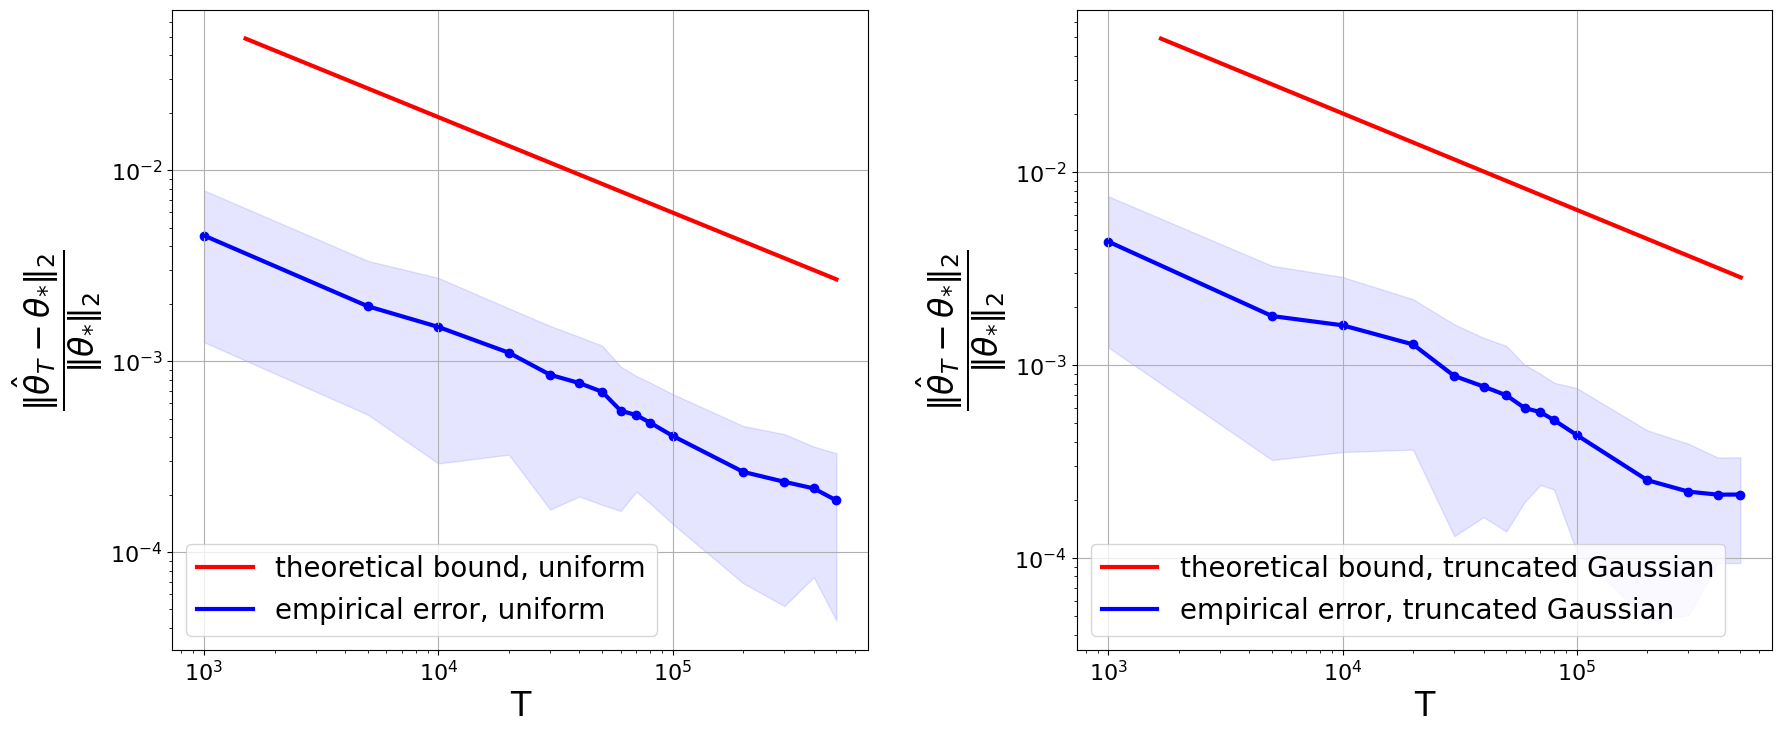

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

normalize = True
log_scale_x = True
log_scale_y = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1



colors = ['red', 'blue', 'cyan', 'pink', 'red', 'magenta', 'orange', 'green']

linewidth_ = 3.0
alpha_ = 0.1

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)   # wspace: space between subplots in a row

# --------------------------------------------------Uniform---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
s_phi = 0.01
p_phi = 0.65
delta = 0.01
# w_max = 0.0001

name1 = 'lse_theo_bound_8_w_uniform_5.773502691896258e-05_s_phi_0.0005_p_phi_0.5_delta_0.01.csv'
name2 = 'lse_theo_bound_9_w_uniform_5.773502691896258e-05_s_phi_0.0005_p_phi_0.5_delta_0.01.csv'
time_list = np.loadtxt(name1, delimiter=',')
theo_bound = 100 * np.loadtxt(name2, delimiter=',')/c_norm
label1 = 'theoretical bound, uniform'
axs[0].plot(time_list[:500000], theo_bound[:500000], color=colors[0], label=label1, linewidth=linewidth_)
# axs[0].scatter(time_list[:500000], theo_bound[:500000], color=colors[0], marker='o')

name1 = 'lse_data1_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1].csv'
name2 = 'lse_data2_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1].csv'
time_hor_ = [1, 1000, 5000]
time_hor_.extend(range(10000, 90000, 10000))
time_hor_.extend(range(100000, 500002, 100000))
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',') * 100
std_theta_hat_list = np.loadtxt(name2, delimiter=',') * 100
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empirical error, uniform'
axs[0].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
axs[0].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

if log_scale_x:
  axs[0].set_xscale('log')
if log_scale_y:
  axs[0].set_yscale('log')

axs[0].set_xlabel('T')
if normalize:
  axs[0].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[0].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

axs[0].legend()



# --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
s_phi = 0.0005
p_phi = 0.5
delta = 0.001
w_max = 0.0001

name1 = 'lse_theo_bound_1_w_trunc_guass_s_phi_0.0005_p_phi_0.5_delta_0.001.csv'
name2 = 'lse_theo_bound_2_w_trunc_guass_s_phi_0.0005_p_phi_0.5_delta_0.001.csv'
time_list = np.loadtxt(name1, delimiter=',')
theo_bound = 100 * np.loadtxt(name2, delimiter=',')/c_norm
label1 = 'theoretical bound, truncated Gaussian'
axs[1].plot(time_list[:500000], theo_bound[:500000], color=colors[0], label=label1, linewidth=linewidth_)
# axs[1].scatter(time_list[:500000], theo_bound[:500000], color=colors[0], marker='o')


name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_hor_ = [1, 1000, 5000]
time_hor_.extend(range(10000, 90000, 10000))
time_hor_.extend(range(100000, 500002, 100000))
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',') * 100
std_theta_hat_list = np.loadtxt(name2, delimiter=',') * 100
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empirical error, truncated Gaussian'
axs[1].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
axs[1].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
axs[1].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)


if log_scale_x:
  axs[1].set_xscale('log')
if log_scale_y:
  axs[1].set_yscale('log')

axs[1].set_xlabel('T')
if normalize:
  axs[1].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[1].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

axs[1].legend()


# fig.suptitle('Pendulum Example')
plt.show()



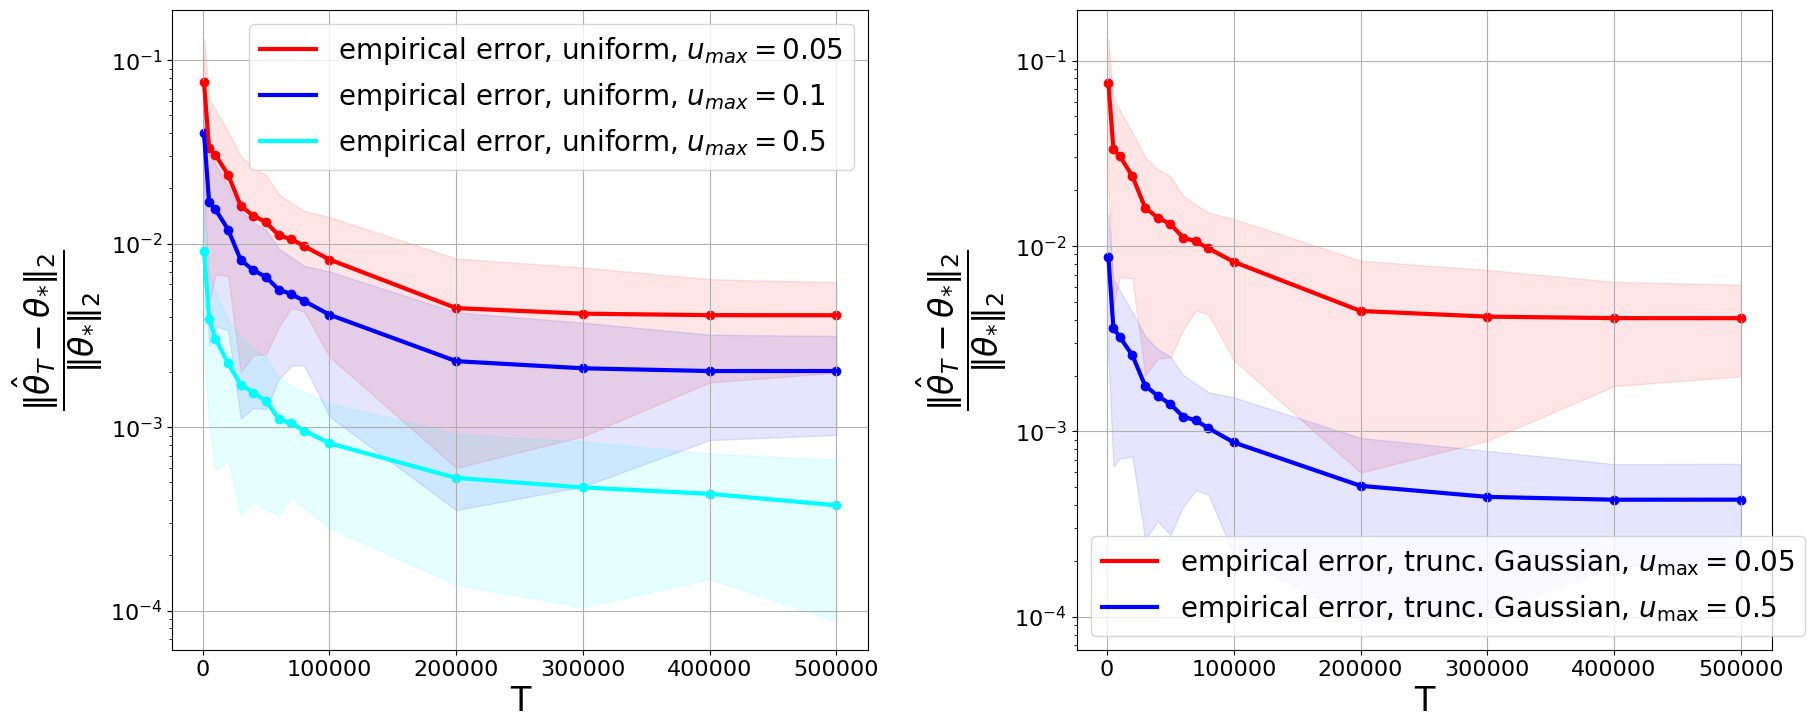

In [299]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

normalize = True
log_scale_x = False
log_scale_y = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1



colors = ['red', 'blue', 'cyan', 'pink', 'red', 'magenta', 'orange', 'green']

linewidth_ = 3.0
alpha_ = 0.1

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)   # wspace: space between subplots in a row

# --------------------------------------------------Uniform---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
s_phi = 0.01
p_phi = 0.65
delta = 0.01
# w_max = 0.0001

# name1 = 'lse_theo_bound_8_w_uniform_5.773502691896258e-05_s_phi_0.0005_p_phi_0.5_delta_0.01.csv'
# name2 = 'lse_theo_bound_9_w_uniform_5.773502691896258e-05_s_phi_0.0005_p_phi_0.5_delta_0.01.csv'
# time_list = np.loadtxt(name1, delimiter=',')
# theo_bound = np.loadtxt(name2, delimiter=',')/c_norm
# label1 = 'theoretical bound, uniform'
# axs[0].plot(time_list[:500000], theo_bound[:500000], color=colors[0], label=label1, linewidth=linewidth_)
# # axs[0].scatter(time_list[:500000], theo_bound[:500000], color=colors[0], marker='o')

time_hor_ = [1, 1000, 5000]
time_hor_.extend(range(10000, 90000, 10000))
time_hor_.extend(range(100000, 500002, 100000))
time_list = time_hor_

name1 = 'lse_data1_w_uniform_[-0.1, 0.1]_u_uniform_[-0.05, 0.05]_[1].csv'
name2 = 'lse_data2_w_uniform_[-0.1, 0.1]_u_uniform_[-0.05, 0.05]_[1].csv'
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empirical error, uniform, $u_{max}=0.05$'
axs[0].plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
axs[0].scatter(time_list[1:], points[1:], color=colors[0], marker='o')
axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

name1 = 'lse_data1_w_uniform_[-0.1, 0.1]_u_uniform_[-0.1, 0.1]_[1].csv'
name2 = 'lse_data2_w_uniform_[-0.1, 0.1]_u_uniform_[-0.1, 0.1]_[1].csv'
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empirical error, uniform, $u_{max}=0.1$'
axs[0].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
axs[0].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

name1 = 'lse_data1_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1].csv'
name2 = 'lse_data2_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1].csv'
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empirical error, uniform, $u_{max}=0.5$'
axs[0].plot(time_list[1:], points[1:], color=colors[2], label=label1, linewidth=linewidth_)
axs[0].scatter(time_list[1:], points[1:], color=colors[2], marker='o')
axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[2], alpha=alpha_)

if log_scale_x:
  axs[0].set_xscale('log')
if log_scale_y:
  axs[0].set_yscale('log')

axs[0].set_xlabel('T')
if normalize:
  axs[0].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[0].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

axs[0].legend()



# --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
# s_phi = 0.0005
# p_phi = 0.5
# delta = 0.001
# w_max = 0.0001

# name1 = 'lse_theo_bound_1_w_trunc_guass_s_phi_0.0005_p_phi_0.5_delta_0.001.csv'
# name2 = 'lse_theo_bound_2_w_trunc_guass_s_phi_0.0005_p_phi_0.5_delta_0.001.csv'
# time_list = np.loadtxt(name1, delimiter=',')
# theo_bound = np.loadtxt(name2, delimiter=',')/c_norm
# label1 = 'theoretical bound, truncated Gaussian'
# axs[1].plot(time_list[:500000], theo_bound[:500000], color=colors[0], label=label1, linewidth=linewidth_)
# # axs[1].scatter(time_list[:500000], theo_bound[:500000], color=colors[0], marker='o')

time_hor_ = [1, 1000, 5000]
time_hor_.extend(range(10000, 90000, 10000))
time_hor_.extend(range(100000, 500002, 100000))
time_list = time_hor_



name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 0.1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 0.1]_[1].csv'
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empirical error, trunc. Gaussian, $u_{\max}=0.05$'
axs[1].plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
axs[1].scatter(time_list[1:], points[1:], color=colors[0], marker='o')
axs[1].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'empirical error, trunc. Gaussian, $u_{\max}=0.5$'
axs[1].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
axs[1].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
axs[1].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)


if log_scale_x:
  axs[1].set_xscale('log')
if log_scale_y:
  axs[1].set_yscale('log')

axs[1].set_xlabel('T')
if normalize:
  axs[1].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[1].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

axs[1].legend()


# fig.suptitle('Pendulum Example')
plt.show()



In [ ]:
print(time_hor_)
print(points[1:])

[1, 1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000]
[4.3539761561597406e-05, 1.791178918784547e-05, 1.604240999945175e-05, 1.2765105541557479e-05, 8.757537806701189e-06, 7.723901086803938e-06, 6.959358600880307e-06, 5.971218718493015e-06, 5.68844096739798e-06, 5.170955248182421e-06, 4.328374537256955e-06, 2.52631496561035e-06, 2.202537248800473e-06, 2.125504802000758e-06, 2.127978186793356e-06]


In [ ]:
print(time_list[0])
print(time_hor_)

1352.0
[1, 1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 100000, 200000, 300000, 400000, 500000]


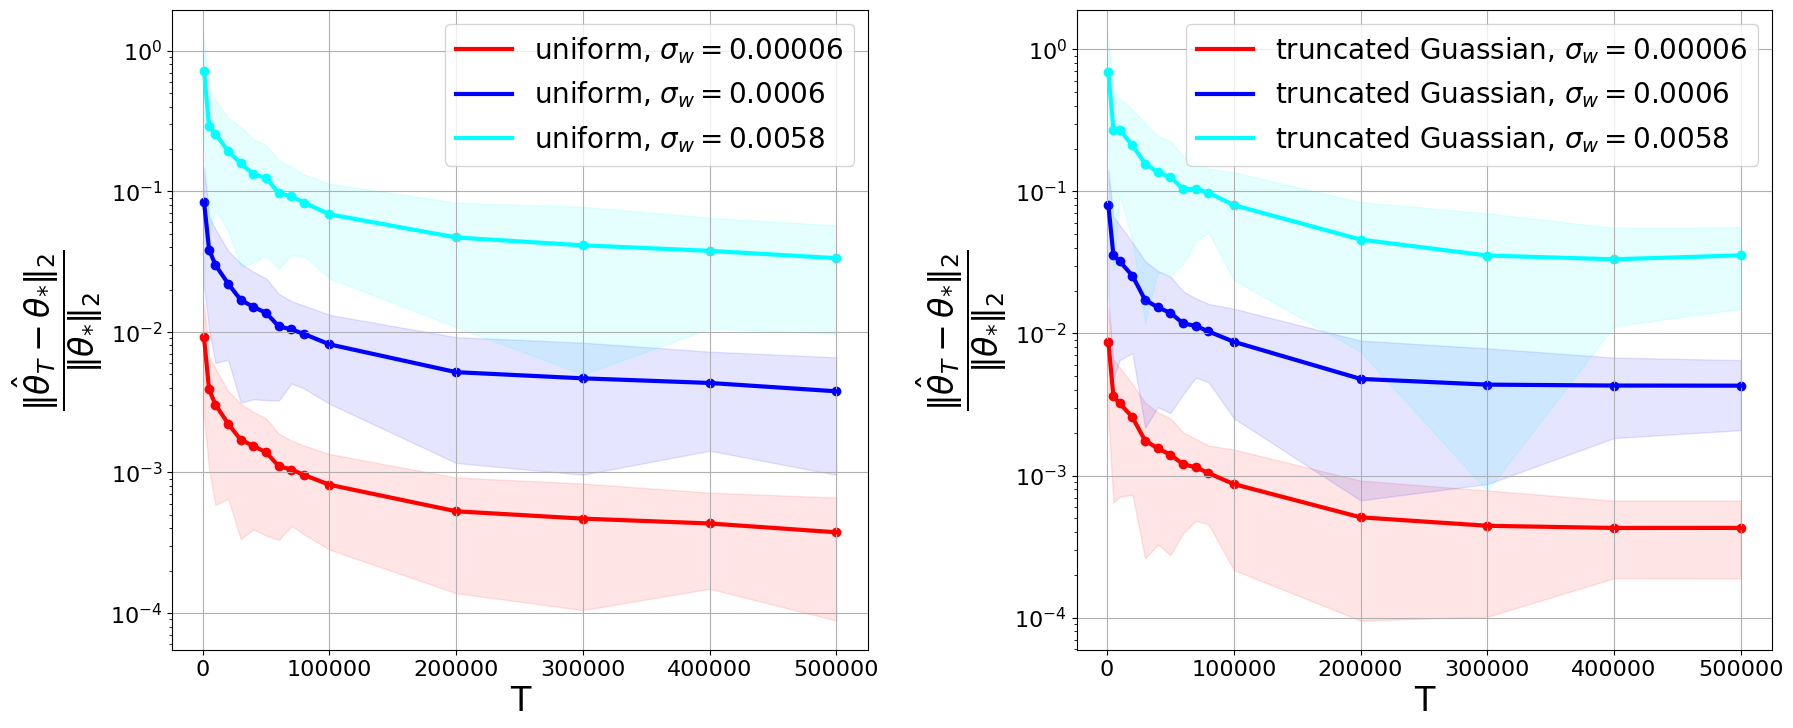

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

normalize = True
log_scale_x = False
log_scale_y = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1


colors = ['red', 'blue', 'cyan', 'black',  'red', 'magenta', 'red']

linewidth_ = 3.0
alpha_ = 0.1

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)   # wspace: space between subplots in a row

# --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.0001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'truncated Guassian, $\sigma_{w}=0.00006$'
axs[1].plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
axs[1].scatter(time_list[1:], points[1:], color=colors[0], marker='o')
axs[1].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.001]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'truncated Guassian, $\sigma_{w}=0.0006$'
axs[1].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
axs[1].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
axs[1].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

name1 = 'lse_data1_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
name2 = 'lse_data2_w_trunc_guass_[0.0, 1000, 0.01]_u_trunc_guass_[0.0, 0.5, 1]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'truncated Guassian, $\sigma_{w}=0.0058$'
axs[1].plot(time_list[1:], points[1:], color=colors[2], label=label1, linewidth=linewidth_)
axs[1].scatter(time_list[1:], points[1:], color=colors[2], marker='o')
axs[1].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[2], alpha=alpha_)

if log_scale_x:
  axs[1].set_xscale('log')
if log_scale_y:
  axs[1].set_yscale('log')

axs[1].set_xlabel('T')
if normalize:
  axs[1].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[1].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

axs[1].legend()


# --------------------------------------------------Uniform---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
name1 = 'lse_data1_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1].csv'
name2 = 'lse_data2_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'uniform, $\sigma_{w}=0.00006$'
axs[0].plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
axs[0].scatter(time_list[1:], points[1:], color=colors[0], marker='o')
axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

name1 = 'lse_data1_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1].csv'
name2 = 'lse_data2_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'uniform, $\sigma_{w}=0.0006$'
axs[0].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
axs[0].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

name1 = 'lse_data1_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1].csv'
name2 = 'lse_data2_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'uniform, $\sigma_{w}=0.0058$'
axs[0].plot(time_list[1:], points[1:], color=colors[2], label=label1, linewidth=linewidth_)
axs[0].scatter(time_list[1:], points[1:], color=colors[2], marker='o')
axs[0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[2], alpha=alpha_)

if log_scale_x:
  axs[0].set_xscale('log')
if log_scale_y:
  axs[0].set_yscale('log')

axs[0].set_xlabel('T')
if normalize:
  axs[0].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[0].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')

axs[0].legend()


# fig.suptitle('Pendulum -- LSE Theoretical Bound (w.p. at least $1-3\delta$ and with $s_{\phi} =0.01$ and $p_{\phi}=0.65$)')
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

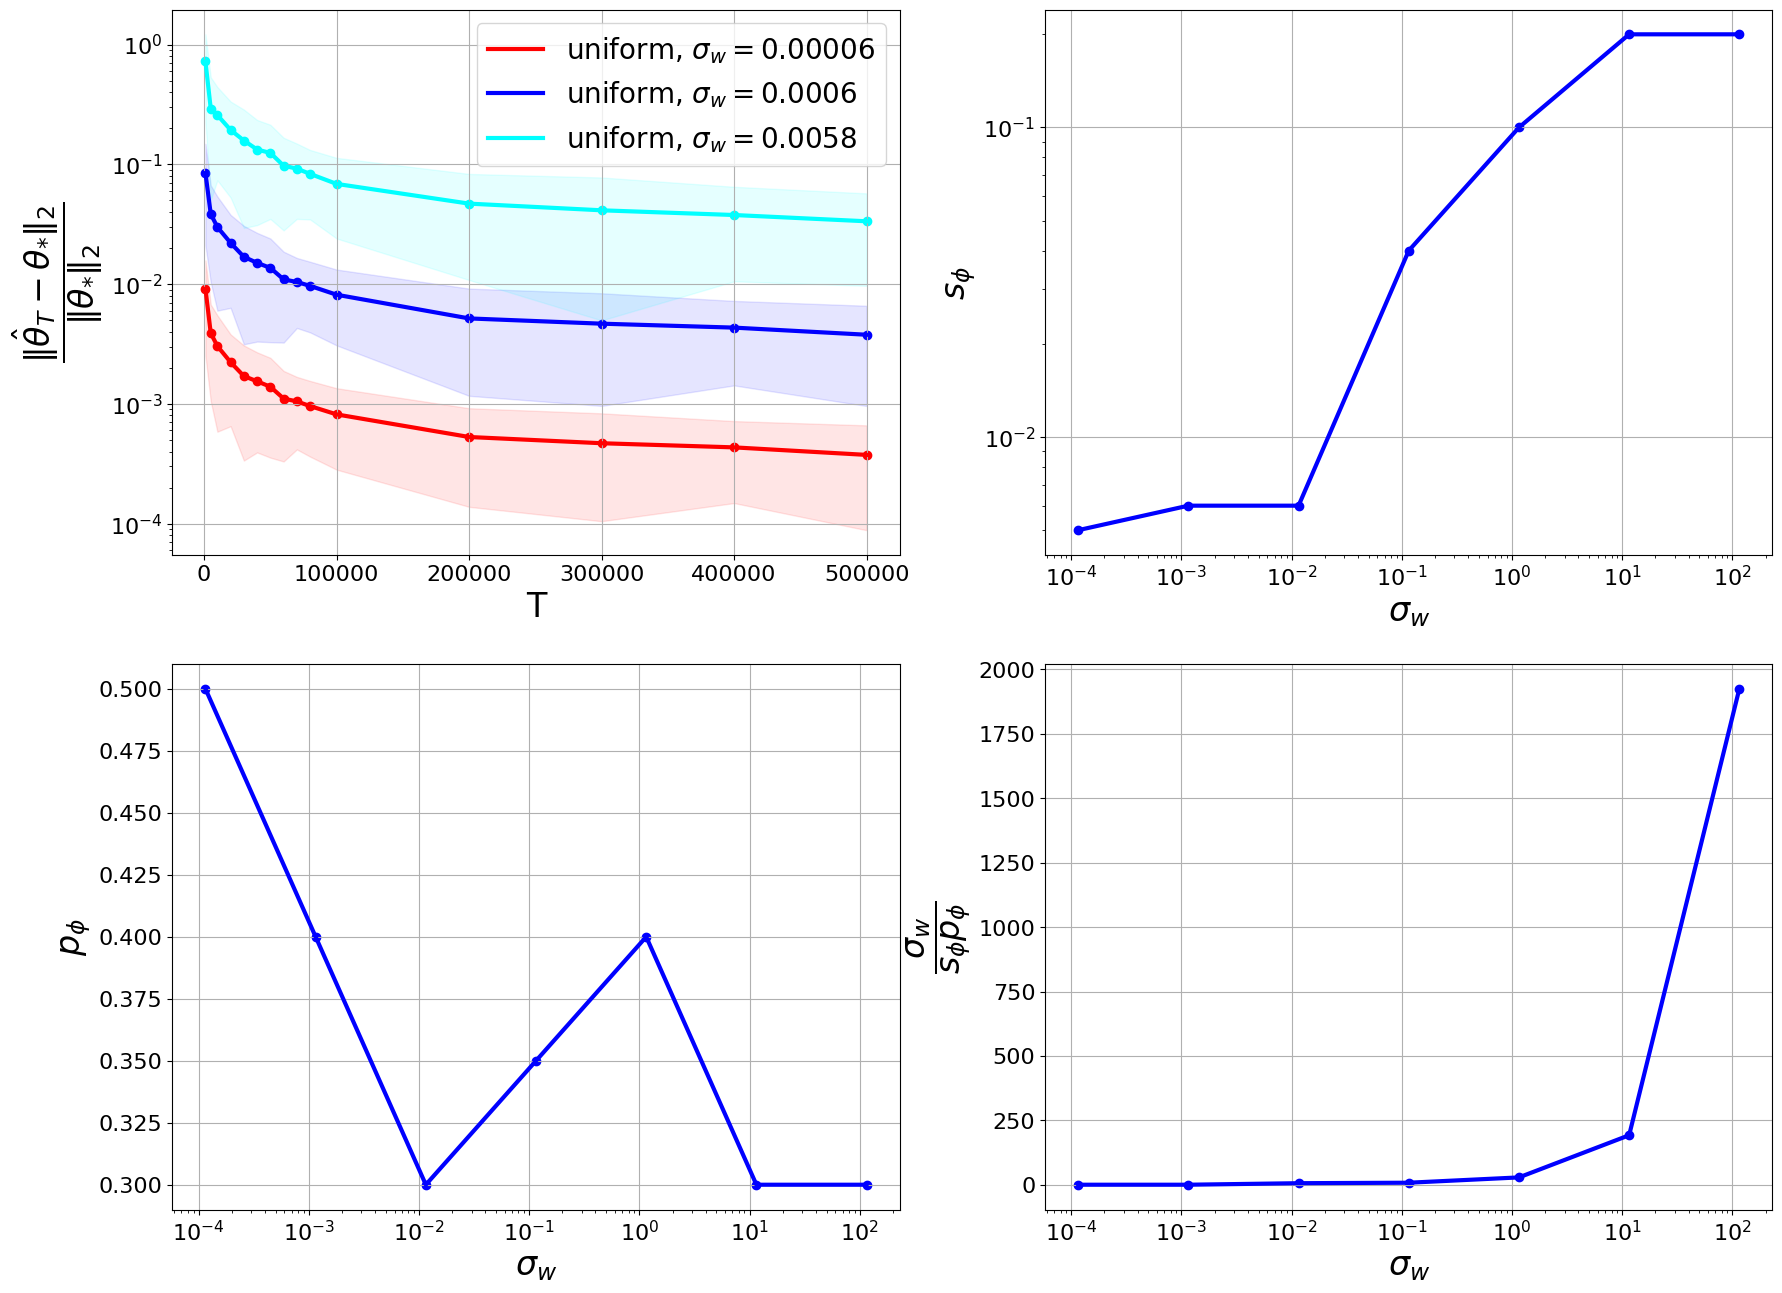

In [329]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

normalize = True
log_scale_x = False
log_scale_y = True

if normalize:
  c_norm = np.linalg.norm(np.array(ground_truth))
else:
  c_norm = 1


colors = ['red', 'blue', 'cyan', 'black',  'red', 'magenta', 'red']

linewidth_ = 3.0
alpha_ = 0.1

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)   # wspace: space between subplots in a row

w_max_list = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
sigma_w_list = (w_max_list * 2)/np.sqrt(3)
s_phi_list = [0.005, 0.006, 0.006, 0.04, 0.1, 0.2, 0.2]
p_phi_list = [0.5, 0.4, 0.3, 0.35, 0.4, 0.3, 0.3]
sp_list = [0.00025, 0.0024, 0.0018, 0.014, 0.04, 0.06, 0.06]

# --------------------------------------------------Truncated Gaussian---------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------
name1 = 'lse_data1_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1].csv'
name2 = 'lse_data2_w_uniform_[-0.1, 0.1]_u_uniform_[-0.5, 0.5]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'uniform, $\sigma_{w}=0.00006$'
axs[0, 0].plot(time_list[1:], points[1:], color=colors[0], label=label1, linewidth=linewidth_)
axs[0, 0].scatter(time_list[1:], points[1:], color=colors[0], marker='o')
axs[0, 0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[0], alpha=alpha_)

name1 = 'lse_data1_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1].csv'
name2 = 'lse_data2_w_uniform_[-1, 1]_u_uniform_[-0.5, 0.5]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'uniform, $\sigma_{w}=0.0006$'
axs[0, 0].plot(time_list[1:], points[1:], color=colors[1], label=label1, linewidth=linewidth_)
axs[0, 0].scatter(time_list[1:], points[1:], color=colors[1], marker='o')
axs[0, 0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[1], alpha=alpha_)

name1 = 'lse_data1_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1].csv'
name2 = 'lse_data2_w_uniform_[-10, 10]_u_uniform_[-0.5, 0.5]_[1].csv'
time_list = time_hor_
mean_theta_hat_list = np.loadtxt(name1, delimiter=',')
std_theta_hat_list = np.loadtxt(name2, delimiter=',')
points = []
errors = []
for j in range(len(mean_theta_hat_list)):
  points.append(np.linalg.norm(mean_theta_hat_list[j]) / c_norm)
  errors.append(np.linalg.norm(std_theta_hat_list[j]) / c_norm)
label1 = 'uniform, $\sigma_{w}=0.0058$'
axs[0, 0].plot(time_list[1:], points[1:], color=colors[2], label=label1, linewidth=linewidth_)
axs[0, 0].scatter(time_list[1:], points[1:], color=colors[2], marker='o')
axs[0, 0].fill_between(time_list[1:], np.array(points[1:]) - np.array(errors[1:]), np.array(points[1:]) + np.array(errors[1:]), color=colors[2], alpha=alpha_)

if log_scale_x:
  axs[0, 0].set_xscale('log')
if log_scale_y:
  axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('T')
if normalize:
  axs[0, 0].set_ylabel('$\dfrac{\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}}{\|\\theta_{*}\|_{2}}$')
else:
  axs[0, 0].set_ylabel('$\|\hat{\\theta}_{T} - \\theta_{*}\|_{2}$')
axs[0, 0].legend()

axs[0, 1].plot(sigma_w_list, np.array(s_phi_list), color=colors[1], label=label1, linewidth=linewidth_)
axs[0, 1].scatter(sigma_w_list, np.array(s_phi_list), color=colors[1], marker='o')
axs[0, 1].set_xlabel('$\sigma_{w}$')
axs[0, 1].set_ylabel('$s_{\phi}$')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')


axs[1, 0].plot(sigma_w_list, np.array(p_phi_list), color=colors[1], label=label1, linewidth=linewidth_)
axs[1, 0].scatter(sigma_w_list, np.array(p_phi_list), color=colors[1], marker='o')
axs[1, 0].set_xlabel('$\sigma_{w}$')
axs[1, 0].set_ylabel('$p_{\phi}$')
axs[1, 0].set_xscale('log')
# axs[1, 0].set_yscale('log')


axs[1, 1].plot(sigma_w_list, np.array(sigma_w_list)/np.array(sp_list), color=colors[1], label=label1, linewidth=linewidth_)
axs[1, 1].scatter(sigma_w_list, np.array(sigma_w_list)/np.array(sp_list), color=colors[1], marker='o')
axs[1, 1].set_xlabel('$\sigma_{w}$')
axs[1, 1].set_ylabel('$\dfrac{\sigma_{w}}{s_{\phi}p_{\phi}}$')
axs[1, 1].set_xscale('log')

plt.show()
